# Von Mises Toy

See if I can implement beta without the big list

In [20]:
import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)

import tensorflow.keras as tfk
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.layers import Flatten, Reshape, Lambda
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model
import tensorflow_probability as tfp
tfkl = tfk.layers
tfd = tfp.distributions
tfpl = tfp.layers
import os
import os.path as osp
import sys
sys.path.append('/home/jcollins')

import numpy as np
from scipy import linalg as LA

import matplotlib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
tfkl.concatenate

<function tensorflow.python.keras.layers.merge.concatenate(inputs, axis=-1, **kwargs)>

In [22]:
def create_dir(dir_path):
    ''' Creates a directory (or nested directories) if they don't exist.
    '''
    if not osp.exists(dir_path):
        os.makedirs(dir_path)

    return dir_path

output_dir = './data/'

In [23]:
def plot_latent_space_2(encoder, valid_data, xrange = [0.9,1e6]):
    latent_valid = np.array(encoder.predict(valid_data))
    perms = np.argsort(np.mean(latent_valid[1],axis=0))
    latent_valid = latent_valid[:,:,perms]
    
    #print(latent_valid.shape)
    plt.figure(figsize=(10,2.5))
    plt.subplot(1,2,1)
    
    
    
    plt.scatter(np.exp(-np.mean(latent_valid[1,:,:],axis=0)/2),np.sqrt(np.mean(np.square(latent_valid[0,:,:]),axis=0)),s=10.)
    plt.semilogx()
    plt.xlim(xrange)
    plt.ylim([0,1.25])
    plt.ylabel(r'$\sqrt{<\mu^2>}$')
    plt.xlabel(r'$<\sigma>^{-1}$')
    
    plt.subplot(1,2,2)
    
    bins = np.logspace(np.log10(xrange[0]),np.log10(xrange[1]),50)

    plt.hist(np.sqrt(np.mean(np.square(latent_valid[0,:,:20]),axis=0) + np.exp(latent_valid[1,:,:20]))/np.exp(latent_valid[1,:,:20]/2),
         bins=bins,stacked=True)

    plt.xlabel("Inverse resolution")
    plt.semilogx()
    plt.xlim(xrange)
    plt.ylim([0,5e4])





    plt.show()

def plot_latent_space(encoder, valid_data):
    latent_valid = np.array(encoder.predict(valid_data))
    perms = np.argsort(np.mean(latent_valid[1],axis=1))
    latent_valid = latent_valid[:,perms,:]
    plt.figure(figsize=(18,4))

    plt.subplot(1,3,1)
    plt.hist(latent_valid[0,:,0],bins=np.arange(-5,5.00001,0.1),label="latent dimension 1",alpha=0.75)
    plt.hist(latent_valid[0,:,1],bins=np.arange(-5,5.00001,0.1),label="latent dimension 2",alpha=0.75)
    plt.title("latent means")
    plt.xlim([-5,5])
    plt.legend()
    
    plt.subplot(1,3,2)
    bins = np.logspace(-0.1,4,100)
    plt.hist(np.sqrt(np.mean(np.square(latent_valid[0,:,0])) + np.exp(latent_valid[1,:,0]))/np.exp(latent_valid[1,:,0]/2),label="latent dimension 1",alpha=0.75,bins=bins)
    plt.hist(np.sqrt(np.mean(np.square(latent_valid[0,:,1])) + np.exp(latent_valid[1,:,1]))/np.exp(latent_valid[1,:,1]/2),label="latent dimension 2",alpha=0.75,bins=bins)
    plt.title("Inverse resolution")
    plt.semilogx()
    plt.xlim([0.9,1e6])
    plt.legend()



    plt.subplot(1,3,3)
    plt.hist(latent_valid[2,:,0],bins=np.arange(-5,5.00001,0.1),label="latent dimension 1",alpha=0.75)
    plt.hist(latent_valid[2,:,1],bins=np.arange(-5,5.00001,0.1),label="latent dimension 2",alpha=0.75)
    plt.title("sampled z")
    plt.xlim([-5,5])
    plt.legend()

    plt.show()
    
def plot_latent_map(encoder, decoder, train_data_banana,
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3]):
    
    
    
    scales = np.array(scales)
    values = np.array(values)
    numpoints = 100
    ranges = scales[:,1]-scales[:,0]

    latent_valid_mu, latent_valid_logvar, latent_valid = np.array(encoder.predict(train_data_banana))
    perms = np.argsort(np.mean(latent_valid_logvar,axis=0))
    
    codes1_proj = np.array([np.vstack([np.ones(numpoints)*value,np.linspace(scales[0,0],scales[0,1],numpoints)]).T for value in values[0]])
    codes2_proj = np.array([np.vstack([np.linspace(scales[1,0],scales[1,1],numpoints),np.ones(numpoints)*value]).T for value in values[1]])

    codes1 = np.zeros((3,numpoints,10))
    codes1[:,:,perms[0]] = codes2_proj[:,:,0]
    codes1[:,:,perms[1]] = codes2_proj[:,:,1]
    codes2 = np.zeros((3,numpoints,10))
    codes2[:,:,perms[0]] = codes1_proj[:,:,0]
    codes2[:,:,perms[1]] = codes1_proj[:,:,1]
#     if long_axis == 0:
#         codes0 = np.array([[code,short_values[0]] for code in codes])
#         codes1 = np.array([[code,short_values[1]] for code in codes])
#         codes2 = np.array([[code,short_values[2]] for code in codes])
#     else:
#         codes0 = np.array([[short_values[0],code] for code in codes])
#         codes1 = np.array([[short_values[1],code] for code in codes])
#         codes2 = np.array([[short_values[2],code] for code in codes])

    fig, ax = plt.subplots(1,2,figsize=(12,3.5),gridspec_kw={'width_ratios': [1, 2]})
    

    
    ax[0].scatter(latent_valid[:,perms[0]],latent_valid[:,perms[1]],color='gray',alpha=0.1,s=0.4)
    ax[1].scatter(train_data_banana[:,0],train_data_banana[:,1],color='gray',alpha=0.1,s=0.4)

    cmap = matplotlib.cm.get_cmap('cool')
    
    for i,codes in enumerate(codes1):
#         points = np.zeros((numpoints,2))
        color = cmap(i/3.)
        points = decoder.predict(codes)
        ax[1].plot(points[:,0],points[:,1],color = color)
        ax[0].plot(codes[:,perms[0]],codes[:,perms[1]],color = color)
        
    cmap = matplotlib.cm.get_cmap('autumn')
    
    for i,codes in enumerate(codes2):
        color = cmap(i/3.)
        points = decoder.predict(codes)
        ax[1].plot(points[:,0],points[:,1],color = color)
        ax[0].plot(codes[:,perms[0]],codes[:,perms[1]],color = color)

#     points = np.zeros((int(long_range/0.01),2))
#     points = decoder.predict(codes1)
#     plt.scatter(points[:,0],points[:,1],label=("latent axis " + str(1-long_axis) + " = " + str(short_values[1])),s=0.5)

#     points = np.zeros((int(long_range/0.01),2))
#     points = decoder.predict(codes2)
# #     plt.scatter(points[:,0],points[:,1],label=("latent axis " + str(1-long_axis) + " = " + str(short_values[2])),s=0.5)
#     plt.plot(points[:,0],points[:,1],label=("latent axis " + str(1-long_axis) + " = " + str(short_values[2])))
    ax[1].set_xlim([-2.5,2.5])
    ax[1].set_ylim([-0.75,1.75])
    ax[0].set_xlim(latent_plotrange)
    ax[0].set_ylim(latent_plotrange)
    #plt.legend()

    plt.show()

## Generate training data

Input data is 2D, generated in the shape of a banana (plotted below) defined by two gaussians with widths 1 and 0.1. The VAE will be tasked with reconstructing the 2D location of the input points, using euclidean distance as the reconstruction error. The latent space is 2D, so can in principle easily encode everything about the input. This will be regulated by the variational latent space

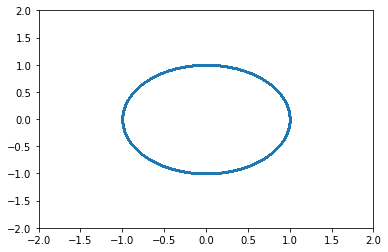

In [651]:
numtrain = 1000000
numvalid = 200000

train_theta = np.random.uniform(-np.pi,np.pi,size=(numtrain))
# train_theta = np.random.normal(size=(numtrain))
train_data = np.zeros((numtrain,2))
train_data[:,0] = np.cos(train_theta)
train_data[:,1] = np.sin(train_theta)

valid_theta = np.random.uniform(-np.pi,np.pi,size=(numvalid))
# valid_theta = np.random.normal(size=(numvalid))
valid_data = np.zeros((numvalid,2))
valid_data[:,0] = np.cos(valid_theta)
valid_data[:,1] = np.sin(valid_theta)



plt.scatter(train_data[:,0],train_data[:,1],s=0.1,alpha=0.1)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

(array([  32.,  167.,  721., 1845., 2715., 2499., 1398.,  513.,  100.,
          10.]),
 array([-3.43236404, -2.72262362, -2.01288321, -1.3031428 , -0.59340239,
         0.11633802,  0.82607843,  1.53581884,  2.24555925,  2.95529966,
         3.66504007]),
 <a list of 10 Patch objects>)

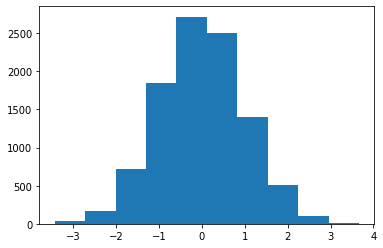

In [236]:
plt.hist(valid_theta)

### Define VAE

In [455]:
from utils.build_vae_oneparticle import make_vae_oneparticle

In [527]:
latent_dims_circle=0
latent_dims_line=4

vae, encoder, decoder = make_vae_oneparticle(loss_type='2D',
                                             real_dim=2,
                                            latent_dims_circle=latent_dims_circle,
                                            latent_dims_line=latent_dims_line)

Model: "model_227"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_153 (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
model_225 (Model)               [(None, 4), (None, 4 9032        input_153[0][0]                  
__________________________________________________________________________________________________
input_154 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
model_226 (Model)               (None, 2)            8770        model_225[1][2]                  
Total params: 17,802
Trainable params: 17,802
Non-trainable params: 0
____________________

In [552]:


last_epoch = 0

for beta in np.logspace(-3,2,6)[2:]:
    
    K.set_value(vae.optimizer.lr,1e-4)
    
    print("\n\nSetting beta to ", beta, "\n\n")
    min_delta=1e-6/beta**2
    reduceLR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=min_delta, cooldown=0, min_lr=0)
    earlystop = tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callbacks = [reduceLR,earlystop]

    beta_train = np.ones(len(train_data))*beta
    beta_valid = np.ones(len(valid_data))*beta
    
    history = vae.fit(x=[train_data,beta_train], y=train_data, batch_size=100,
                    epochs=10000,verbose=1,#initial_epoch=history.epoch[-1],
                    validation_data = ([valid_data,beta_valid],valid_data),
                    initial_epoch = last_epoch,
                    callbacks=callbacks
                  )

    last_epoch = history.epoch[-1]


    tfk.models.save_model(vae,"von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_model.hdf5")
    vae.save_weights("von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_weights.hdf5")



Setting beta to  0.1 


Train on 100000 samples, validate on 10000 samples
Epoch 1/10000
100000/100000 [==============================] - 6s 55us/sample - loss: 4.3124 - recon_loss: 0.0077 - kl_loss: 3.5393 - val_loss: 4.3717 - val_recon_loss: 0.0090 - val_kl_loss: 3.4684
Epoch 2/10000
100000/100000 [==============================] - 5s 55us/sample - loss: 4.3076 - recon_loss: 0.0077 - kl_loss: 3.5338 - val_loss: 4.3190 - val_recon_loss: 0.0080 - val_kl_loss: 3.5233
Epoch 3/10000
100000/100000 [==============================] - 5s 55us/sample - loss: 4.3289 - recon_loss: 0.0079 - kl_loss: 3.5357 - val_loss: 4.3712 - val_recon_loss: 0.0084 - val_kl_loss: 3.5318
Epoch 4/10000
 99400/100000 [============================>.] - ETA: 0s - loss: 4.3068 - recon_loss: 0.0078 - kl_loss: 3.5232
Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
100000/100000 [==============================] - 6s 57us/sample - loss: 4.3057 - recon_loss: 0.0078 - kl_loss: 3.5231 - val_

KeyboardInterrupt: 

In [556]:


#last_epoch = 0

for beta in np.logspace(1,-2,7)[2:]:
    
    K.set_value(vae.optimizer.lr,1e-4)
    
    print("\n\nSetting beta to ", beta, "\n\n")
    min_delta=1e-6/beta**2
    reduceLR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=min_delta, cooldown=0, min_lr=0)
    earlystop = tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callbacks = [reduceLR,earlystop]

    beta_train = np.ones(len(train_data))*beta
    beta_valid = np.ones(len(valid_data))*beta
    
    history = vae.fit(x=[train_data,beta_train], y=train_data, batch_size=100,
                    epochs=10000,verbose=1,#initial_epoch=history.epoch[-1],
                    validation_data = ([valid_data,beta_valid],valid_data),
                    initial_epoch = last_epoch,
                    callbacks=callbacks
                  )

    last_epoch = history.epoch[-1]


    tfk.models.save_model(vae,"von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_model.hdf5")
    vae.save_weights("von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_weights.hdf5")



Setting beta to  1.0 


Train on 100000 samples, validate on 10000 samples
Epoch 21/10000
100000/100000 [==============================] - 6s 56us/sample - loss: 1.0012 - recon_loss: 0.9973 - kl_loss: 0.0039 - val_loss: 1.0008 - val_recon_loss: 0.9940 - val_kl_loss: 0.0068
Epoch 22/10000
100000/100000 [==============================] - 6s 56us/sample - loss: 1.0010 - recon_loss: 0.9953 - kl_loss: 0.0058 - val_loss: 1.0006 - val_recon_loss: 0.9969 - val_kl_loss: 0.0037
Epoch 23/10000
100000/100000 [==============================] - 6s 56us/sample - loss: 1.0011 - recon_loss: 0.9989 - kl_loss: 0.0022 - val_loss: 1.0013 - val_recon_loss: 1.0002 - val_kl_loss: 0.0012
Epoch 24/10000
 99200/100000 [============================>.] - ETA: 0s - loss: 1.0004 - recon_loss: 0.9974 - kl_loss: 0.0030
Epoch 00024: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
100000/100000 [==============================] - 6s 56us/sample - loss: 1.0004 - recon_loss: 0.9974 - kl_loss: 0.0030 - 

Epoch 50/10000
100000/100000 [==============================] - 6s 55us/sample - loss: 6.1994 - recon_loss: 0.0013 - kl_loss: 4.9162 - val_loss: 5.8856 - val_recon_loss: 9.2893e-04 - val_kl_loss: 4.9567
Epoch 51/10000
100000/100000 [==============================] - 6s 55us/sample - loss: 6.3793 - recon_loss: 0.0015 - kl_loss: 4.9144 - val_loss: 6.2963 - val_recon_loss: 0.0014 - val_kl_loss: 4.9017
Epoch 52/10000
 99700/100000 [============================>.] - ETA: 0s - loss: 6.3662 - recon_loss: 0.0015 - kl_loss: 4.9092
Epoch 00052: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
100000/100000 [==============================] - 6s 58us/sample - loss: 6.3646 - recon_loss: 0.0015 - kl_loss: 4.9093 - val_loss: 6.2175 - val_recon_loss: 0.0012 - val_kl_loss: 4.9704
Epoch 53/10000
100000/100000 [==============================] - 6s 56us/sample - loss: 6.2146 - recon_loss: 0.0013 - kl_loss: 4.9002 - val_loss: 6.6823 - val_recon_loss: 0.0018 - val_kl_loss: 4.8613
Epoch 54/

In [571]:
#last_epoch = 0

for beta in np.logspace(-2,1,13)[1:]:
    
    K.set_value(vae.optimizer.lr,1e-4)
    
    print("\n\nSetting beta to ", beta, "\n\n")
    min_delta=1e-6/beta**2
    reduceLR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=min_delta, cooldown=0, min_lr=0)
    earlystop = tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callbacks = [reduceLR,earlystop]

    beta_train = np.ones(len(train_data))*beta
    beta_valid = np.ones(len(valid_data))*beta
    
    history = vae.fit(x=[train_data,beta_train], y=train_data, batch_size=100,
                    epochs=10000,verbose=1,#initial_epoch=history.epoch[-1],
                    validation_data = ([valid_data,beta_valid],valid_data),
                    initial_epoch = last_epoch,
                    callbacks=callbacks
                  )

    last_epoch = history.epoch[-1]


    tfk.models.save_model(vae,"von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_model.hdf5")
    vae.save_weights("von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_weights.hdf5")



Setting beta to  0.01778279410038923 


Train on 100000 samples, validate on 10000 samples
Epoch 59/10000
100000/100000 [==============================] - 6s 57us/sample - loss: 7.7848 - recon_loss: 6.7690e-04 - kl_loss: 5.6442 - val_loss: 8.1413 - val_recon_loss: 8.0890e-04 - val_kl_loss: 5.5833
Epoch 60/10000
100000/100000 [==============================] - 6s 57us/sample - loss: 7.9144 - recon_loss: 7.2727e-04 - kl_loss: 5.6146 - val_loss: 7.1720 - val_recon_loss: 4.8648e-04 - val_kl_loss: 5.6336
Epoch 61/10000
100000/100000 [==============================] - 6s 55us/sample - loss: 7.7611 - recon_loss: 6.7996e-04 - kl_loss: 5.6108 - val_loss: 6.8766 - val_recon_loss: 4.1867e-04 - val_kl_loss: 5.5526
Epoch 62/10000
100000/100000 [==============================] - 6s 55us/sample - loss: 7.9534 - recon_loss: 7.4178e-04 - kl_loss: 5.6077 - val_loss: 7.4096 - val_recon_loss: 5.7818e-04 - val_kl_loss: 5.5813
Epoch 63/10000
 99400/100000 [============================>.] - ETA: 0s - loss:

Epoch 86/10000
100000/100000 [==============================] - 5s 55us/sample - loss: 3.5293 - recon_loss: 0.0246 - kl_loss: 2.7502 - val_loss: 3.4406 - val_recon_loss: 0.0215 - val_kl_loss: 2.7620
Epoch 87/10000
100000/100000 [==============================] - 6s 55us/sample - loss: 3.5351 - recon_loss: 0.0244 - kl_loss: 2.7627 - val_loss: 3.4915 - val_recon_loss: 0.0228 - val_kl_loss: 2.7698
Epoch 88/10000
 99100/100000 [============================>.] - ETA: 0s - loss: 3.5129 - recon_loss: 0.0241 - kl_loss: 2.7511
Epoch 00088: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
100000/100000 [==============================] - 6s 56us/sample - loss: 3.5138 - recon_loss: 0.0241 - kl_loss: 2.7511 - val_loss: 3.5700 - val_recon_loss: 0.0259 - val_kl_loss: 2.7519
Epoch 89/10000
100000/100000 [==============================] - 6s 56us/sample - loss: 3.5055 - recon_loss: 0.0239 - kl_loss: 2.7506 - val_loss: 3.5375 - val_recon_loss: 0.0248 - val_kl_loss: 2.7524
Epoch 90/1000

100000/100000 [==============================] - 5s 52us/sample - loss: 0.3166 - recon_loss: 1.0006 - kl_loss: 1.3688e-04 - val_loss: 0.3167 - val_recon_loss: 1.0009 - val_kl_loss: 1.7796e-04
Epoch 113/10000
 99500/100000 [============================>.] - ETA: 0s - loss: 0.3166 - recon_loss: 1.0007 - kl_loss: 1.1168e-04
Epoch 00113: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
100000/100000 [==============================] - 5s 52us/sample - loss: 0.3166 - recon_loss: 1.0007 - kl_loss: 1.1160e-04 - val_loss: 0.3166 - val_recon_loss: 1.0009 - val_kl_loss: 8.6189e-05
Epoch 114/10000
100000/100000 [==============================] - 5s 51us/sample - loss: 0.3164 - recon_loss: 1.0003 - kl_loss: 5.9960e-05 - val_loss: 0.3163 - val_recon_loss: 1.0001 - val_kl_loss: 5.7012e-05
Epoch 115/10000
100000/100000 [==============================] - 5s 53us/sample - loss: 0.3163 - recon_loss: 1.0002 - kl_loss: 5.3950e-05 - val_loss: 0.3163 - val_recon_loss: 1.0002 - val_kl_loss: 

100000/100000 [==============================] - 5s 53us/sample - loss: 0.0316 - recon_loss: 1.0002 - kl_loss: 3.9881e-06 - val_loss: 0.0316 - val_recon_loss: 1.0001 - val_kl_loss: 3.9181e-06
Epoch 142/10000
 99100/100000 [============================>.] - ETA: 0s - loss: 0.0316 - recon_loss: 1.0002 - kl_loss: 3.9024e-06
Epoch 00142: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
100000/100000 [==============================] - 5s 53us/sample - loss: 0.0316 - recon_loss: 1.0002 - kl_loss: 3.9027e-06 - val_loss: 0.0316 - val_recon_loss: 1.0000 - val_kl_loss: 3.7409e-06
Epoch 143/10000
100000/100000 [==============================] - 5s 53us/sample - loss: 0.0316 - recon_loss: 1.0002 - kl_loss: 3.4973e-06 - val_loss: 0.0316 - val_recon_loss: 1.0003 - val_kl_loss: 3.4930e-06
Epoch 144/10000
 99400/100000 [============================>.] - ETA: 0s - loss: 0.0316 - recon_loss: 1.0002 - kl_loss: 3.4847e-06
Epoch 00144: ReduceLROnPlateau reducing learning rate to 9.9999999

In [573]:
#last_epoch = 0

for beta in np.logspace(1,-2,16)[1:]:
    
    K.set_value(vae.optimizer.lr,1e-4)
    
    print("\n\nSetting beta to ", beta, "\n\n")
    min_delta=1e-6/beta**2
    reduceLR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=min_delta, cooldown=0, min_lr=0)
    earlystop = tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callbacks = [reduceLR,earlystop]

    beta_train = np.ones(len(train_data))*beta
    beta_valid = np.ones(len(valid_data))*beta
    
    history = vae.fit(x=[train_data,beta_train], y=train_data, batch_size=100,
                    epochs=10000,verbose=1,#initial_epoch=history.epoch[-1],
                    validation_data = ([valid_data,beta_valid],valid_data),
                    initial_epoch = last_epoch,
                    callbacks=callbacks
                  )

    last_epoch = history.epoch[-1]


    tfk.models.save_model(vae,"von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_model.hdf5")
    vae.save_weights("von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_weights.hdf5")



Setting beta to  6.309573444801933 


Train on 100000 samples, validate on 10000 samples
Epoch 166/10000
100000/100000 [==============================] - 5s 55us/sample - loss: 0.0252 - recon_loss: 1.0009 - kl_loss: 3.6647e-05 - val_loss: 0.0251 - val_recon_loss: 1.0003 - val_kl_loss: 4.6638e-06
Epoch 167/10000
100000/100000 [==============================] - 6s 57us/sample - loss: 0.0251 - recon_loss: 1.0007 - kl_loss: 3.9268e-06 - val_loss: 0.0251 - val_recon_loss: 1.0006 - val_kl_loss: 3.5958e-06
Epoch 168/10000
 99100/100000 [============================>.] - ETA: 0s - loss: 0.0251 - recon_loss: 1.0006 - kl_loss: 3.8263e-06
Epoch 00168: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
100000/100000 [==============================] - 6s 55us/sample - loss: 0.0251 - recon_loss: 1.0006 - kl_loss: 3.8289e-06 - val_loss: 0.0251 - val_recon_loss: 1.0007 - val_kl_loss: 3.4752e-06
Epoch 169/10000
100000/100000 [==============================] - 6s 55us/sample - loss: 0.

100000/100000 [==============================] - 5s 54us/sample - loss: 0.3982 - recon_loss: 1.0002 - kl_loss: 2.1428e-05 - val_loss: 0.3981 - val_recon_loss: 1.0000 - val_kl_loss: 1.8102e-05
Epoch 193/10000
100000/100000 [==============================] - 6s 55us/sample - loss: 0.3982 - recon_loss: 1.0002 - kl_loss: 1.3885e-05 - val_loss: 0.3981 - val_recon_loss: 1.0001 - val_kl_loss: 9.0550e-06
Epoch 194/10000
 99800/100000 [============================>.] - ETA: 0s - loss: 0.3982 - recon_loss: 1.0001 - kl_loss: 9.1357e-06
Epoch 00194: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
100000/100000 [==============================] - 6s 55us/sample - loss: 0.3982 - recon_loss: 1.0001 - kl_loss: 9.1370e-06 - val_loss: 0.3982 - val_recon_loss: 1.0002 - val_kl_loss: 1.3488e-05
Epoch 195/10000
100000/100000 [==============================] - 6s 56us/sample - loss: 0.3982 - recon_loss: 1.0002 - kl_loss: 5.4728e-06 - val_loss: 0.3982 - val_recon_loss: 1.0002 - val_kl_loss: 

100000/100000 [==============================] - 5s 55us/sample - loss: 3.0889 - recon_loss: 0.0473 - kl_loss: 2.3391 - val_loss: 3.0993 - val_recon_loss: 0.0463 - val_kl_loss: 2.3655
Epoch 219/10000
 99500/100000 [============================>.] - ETA: 0s - loss: 3.0794 - recon_loss: 0.0461 - kl_loss: 2.3492
Epoch 00219: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
100000/100000 [==============================] - 6s 57us/sample - loss: 3.0789 - recon_loss: 0.0460 - kl_loss: 2.3492 - val_loss: 3.0866 - val_recon_loss: 0.0474 - val_kl_loss: 2.3352
Epoch 220/10000
100000/100000 [==============================] - 6s 58us/sample - loss: 3.0638 - recon_loss: 0.0459 - kl_loss: 2.3362 - val_loss: 3.0785 - val_recon_loss: 0.0468 - val_kl_loss: 2.3367
Epoch 221/10000
100000/100000 [==============================] - 6s 56us/sample - loss: 3.0711 - recon_loss: 0.0458 - kl_loss: 2.3451 - val_loss: 3.0565 - val_recon_loss: 0.0437 - val_kl_loss: 2.3633
Epoch 222/10000
100000/10

100000/100000 [==============================] - 5s 52us/sample - loss: 5.2454 - recon_loss: 0.0048 - kl_loss: 4.0312 - val_loss: 5.3170 - val_recon_loss: 0.0053 - val_kl_loss: 3.9895
Epoch 247/10000
100000/100000 [==============================] - 5s 54us/sample - loss: 5.2447 - recon_loss: 0.0049 - kl_loss: 4.0252 - val_loss: 5.2260 - val_recon_loss: 0.0047 - val_kl_loss: 4.0508
Epoch 248/10000
100000/100000 [==============================] - 5s 54us/sample - loss: 5.2729 - recon_loss: 0.0049 - kl_loss: 4.0458 - val_loss: 5.1516 - val_recon_loss: 0.0044 - val_kl_loss: 4.0395
Epoch 249/10000
100000/100000 [==============================] - 5s 55us/sample - loss: 5.2305 - recon_loss: 0.0047 - kl_loss: 4.0446 - val_loss: 4.9890 - val_recon_loss: 0.0035 - val_kl_loss: 4.1037
Epoch 250/10000
100000/100000 [==============================] - 5s 53us/sample - loss: 5.3322 - recon_loss: 0.0050 - kl_loss: 4.0735 - val_loss: 5.2606 - val_recon_loss: 0.0044 - val_kl_loss: 4.1433
Epoch 251/10000


 99400/100000 [============================>.] - ETA: 0s - loss: 10.0432 - recon_loss: 3.4696e-04 - kl_loss: 6.5736
Epoch 00273: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
100000/100000 [==============================] - 6s 55us/sample - loss: 10.0361 - recon_loss: 3.4620e-04 - kl_loss: 6.5741 - val_loss: 10.4207 - val_recon_loss: 3.7796e-04 - val_kl_loss: 6.6411
Epoch 274/10000
100000/100000 [==============================] - 5s 53us/sample - loss: 8.6607 - recon_loss: 2.0669e-04 - kl_loss: 6.5937 - val_loss: 9.9009 - val_recon_loss: 3.3551e-04 - val_kl_loss: 6.5459
Epoch 275/10000
 99500/100000 [============================>.] - ETA: 0s - loss: 9.8630 - recon_loss: 3.3310e-04 - kl_loss: 6.5320
Epoch 00275: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
100000/100000 [==============================] - 5s 54us/sample - loss: 9.8518 - recon_loss: 3.3196e-04 - kl_loss: 6.5323 - val_loss: 8.6589 - val_recon_loss: 2.1152e-04 - val_kl_loss: 6.5437

In [626]:
#last_epoch = 0
#vae.load_weights('von_mises_linear_beta_0.01_274_weights.hdf5')
for beta in np.logspace(-2,-3,5)[1:]:
    
    K.set_value(vae.optimizer.lr,1e-4)
    
    print("\n\nSetting beta to ", beta, "\n\n")
    min_delta=1e-8/beta**2
    reduceLR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=min_delta, cooldown=0, min_lr=0)
    earlystop = tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callbacks = [reduceLR,earlystop]

    beta_train = np.ones(len(train_data))*beta
    beta_valid = np.ones(len(valid_data))*beta
    
    history = vae.fit(x=[train_data,beta_train], y=train_data, batch_size=100,
                    epochs=10000,verbose=1,#initial_epoch=history.epoch[-1],
                    validation_data = ([valid_data,beta_valid],valid_data),
                    initial_epoch = last_epoch,
                    callbacks=callbacks
                  )

    last_epoch = history.epoch[-1]


    tfk.models.save_model(vae,"von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_model.hdf5")
    vae.save_weights("von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_weights.hdf5")



Setting beta to  0.005623413251903491 


Train on 100000 samples, validate on 10000 samples
Epoch 283/10000
100000/100000 [==============================] - 5s 54us/sample - loss: 10.2402 - recon_loss: 9.5955e-05 - kl_loss: 7.2058 - val_loss: 10.0411 - val_recon_loss: 8.8462e-05 - val_kl_loss: 7.2437
Epoch 284/10000
100000/100000 [==============================] - 5s 53us/sample - loss: 10.9972 - recon_loss: 1.2062e-04 - kl_loss: 7.1828 - val_loss: 9.6180 - val_recon_loss: 7.7524e-05 - val_kl_loss: 7.1665
Epoch 285/10000
100000/100000 [==============================] - 5s 53us/sample - loss: 11.8468 - recon_loss: 1.4565e-04 - kl_loss: 7.2409 - val_loss: 11.3581 - val_recon_loss: 1.2799e-04 - val_kl_loss: 7.3105
Epoch 286/10000
 99200/100000 [============================>.] - ETA: 0s - loss: 10.7307 - recon_loss: 1.1016e-04 - kl_loss: 7.2472
Epoch 00286: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
100000/100000 [==============================] - 5s 52us/sample -

100000/100000 [==============================] - 5s 53us/sample - loss: 10.8655 - recon_loss: 5.9848e-06 - kl_loss: 8.9729 - val_loss: 11.0901 - val_recon_loss: 6.7186e-06 - val_kl_loss: 8.9655
Epoch 313/10000
 99800/100000 [============================>.] - ETA: 0s - loss: 10.8556 - recon_loss: 6.0118e-06 - kl_loss: 8.9545
Epoch 00313: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
100000/100000 [==============================] - 5s 54us/sample - loss: 10.8551 - recon_loss: 6.0103e-06 - kl_loss: 8.9545 - val_loss: 10.8323 - val_recon_loss: 6.0653e-06 - val_kl_loss: 8.9143
Epoch 314/10000
100000/100000 [==============================] - 5s 54us/sample - loss: 10.6506 - recon_loss: 5.4748e-06 - kl_loss: 8.9194 - val_loss: 10.6235 - val_recon_loss: 5.3759e-06 - val_kl_loss: 8.9235
Epoch 315/10000
100000/100000 [==============================] - 5s 53us/sample - loss: 10.6215 - recon_loss: 5.3506e-06 - kl_loss: 8.9294 - val_loss: 10.5648 - val_recon_loss: 5.1725e-06 - 

In [ ]:
#last_epoch = 0
vae.load_weights('von_mises_linear_upward_0.001_weights.hdf5')
for beta in np.logspace(-3,1,33):
    
    K.set_value(vae.optimizer.lr,1e-4)
    
    print("\n\nSetting beta to ", beta, "\n\n")
    min_delta=1e-8/beta**2
    reduceLR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, mode='auto', min_delta=min_delta, cooldown=0, min_lr=0)
    earlystop = tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=6, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callbacks = [reduceLR,earlystop]

    beta_train = np.ones(len(train_data))*beta
    beta_valid = np.ones(len(valid_data))*beta
    
    history = vae.fit(x=[train_data,beta_train], y=train_data, batch_size=1000,
                    epochs=10000,verbose=1,#initial_epoch=history.epoch[-1],
                    validation_data = ([valid_data,beta_valid],valid_data),
                    initial_epoch = last_epoch,
                    callbacks=callbacks
                  )

    last_epoch = history.epoch[-1]


    tfk.models.save_model(vae,"von_mises_linear_upward_" + str(beta) + "_model.hdf5")
    vae.save_weights("von_mises_linear_upward_" + str(beta) + "_weights.hdf5")



Setting beta to  0.001 


Train on 1000000 samples, validate on 200000 samples
Epoch 567/10000
1000000/1000000 [==============================] - 12s 12us/sample - loss: 19.3731 - recon_loss: 8.7242e-06 - kl_loss: 10.6488 - val_loss: 17.8505 - val_recon_loss: 7.1753e-06 - val_kl_loss: 10.6753
Epoch 568/10000
1000000/1000000 [==============================] - 12s 12us/sample - loss: 19.2138 - recon_loss: 8.5733e-06 - kl_loss: 10.6405 - val_loss: 19.6361 - val_recon_loss: 8.9930e-06 - val_kl_loss: 10.6431
Epoch 569/10000
1000000/1000000 [==============================] - 12s 12us/sample - loss: 19.2302 - recon_loss: 8.6007e-06 - kl_loss: 10.6295 - val_loss: 17.0389 - val_recon_loss: 6.4258e-06 - val_kl_loss: 10.6131
Epoch 570/10000
1000000/1000000 [==============================] - 12s 12us/sample - loss: 19.2308 - recon_loss: 8.6098e-06 - kl_loss: 10.6211 - val_loss: 20.8801 - val_recon_loss: 1.0238e-05 - val_kl_loss: 10.6423
Epoch 571/10000
1000000/1000000 [==========================

1000000/1000000 [==============================] - 12s 12us/sample - loss: 11.9718 - recon_loss: 1.4854e-06 - kl_loss: 10.4865 - val_loss: 11.9732 - val_recon_loss: 1.4837e-06 - val_kl_loss: 10.4895


Setting beta to  0.001333521432163324 


Train on 1000000 samples, validate on 200000 samples
Epoch 601/10000
1000000/1000000 [==============================] - 12s 12us/sample - loss: 24.8489 - recon_loss: 2.6447e-05 - kl_loss: 9.9765 - val_loss: 14.9413 - val_recon_loss: 8.9425e-06 - val_kl_loss: 9.9125
Epoch 602/10000
1000000/1000000 [==============================] - 12s 12us/sample - loss: 14.9227 - recon_loss: 8.8883e-06 - kl_loss: 9.9245 - val_loss: 15.5658 - val_recon_loss: 1.0062e-05 - val_kl_loss: 9.9076
Epoch 603/10000
1000000/1000000 [==============================] - 12s 12us/sample - loss: 14.9450 - recon_loss: 8.9714e-06 - kl_loss: 9.9000 - val_loss: 15.1415 - val_recon_loss: 9.3034e-06 - val_kl_loss: 9.9098
Epoch 604/10000
1000000/1000000 [==============================] -

1000000/1000000 [==============================] - 12s 12us/sample - loss: 10.9181 - recon_loss: 2.2391e-06 - kl_loss: 9.6590 - val_loss: 10.9150 - val_recon_loss: 2.2278e-06 - val_kl_loss: 9.6622
Epoch 636/10000
1000000/1000000 [==============================] - 12s 12us/sample - loss: 10.9197 - recon_loss: 2.2415e-06 - kl_loss: 9.6592 - val_loss: 10.9267 - val_recon_loss: 2.2482e-06 - val_kl_loss: 9.6624
Epoch 637/10000
1000000/1000000 [==============================] - 12s 12us/sample - loss: 10.9186 - recon_loss: 2.2394e-06 - kl_loss: 9.6593 - val_loss: 10.9254 - val_recon_loss: 2.2469e-06 - val_kl_loss: 9.6619
Epoch 638/10000
1000000/1000000 [==============================] - 12s 12us/sample - loss: 10.9190 - recon_loss: 2.2417e-06 - kl_loss: 9.6584 - val_loss: 10.9181 - val_recon_loss: 2.2346e-06 - val_kl_loss: 9.6616
Epoch 639/10000
 998000/1000000 [============================>.] - ETA: 0s - loss: 10.9183 - recon_loss: 2.2410e-06 - kl_loss: 9.6581
Epoch 00639: ReduceLROnPlateau

Epoch 669/10000
1000000/1000000 [==============================] - 14s 14us/sample - loss: 10.0961 - recon_loss: 3.5422e-06 - kl_loss: 8.9759 - val_loss: 10.0945 - val_recon_loss: 3.5266e-06 - val_kl_loss: 8.9793
Epoch 670/10000
1000000/1000000 [==============================] - 14s 14us/sample - loss: 10.0940 - recon_loss: 3.5363e-06 - kl_loss: 8.9757 - val_loss: 10.0911 - val_recon_loss: 3.5163e-06 - val_kl_loss: 8.9791
Epoch 671/10000
1000000/1000000 [==============================] - 13s 13us/sample - loss: 10.0977 - recon_loss: 3.5497e-06 - kl_loss: 8.9752 - val_loss: 10.1008 - val_recon_loss: 3.5487e-06 - val_kl_loss: 8.9786
Epoch 672/10000
1000000/1000000 [==============================] - 14s 14us/sample - loss: 10.0940 - recon_loss: 3.5374e-06 - kl_loss: 8.9754 - val_loss: 10.0904 - val_recon_loss: 3.5141e-06 - val_kl_loss: 8.9791
Epoch 673/10000
1000000/1000000 [==============================] - 14s 14us/sample - loss: 10.0913 - recon_loss: 3.5289e-06 - kl_loss: 8.9754 - val_

1000000/1000000 [==============================] - 14s 14us/sample - loss: 9.5273 - recon_loss: 6.7768e-06 - kl_loss: 8.3222 - val_loss: 9.3349 - val_recon_loss: 5.6866e-06 - val_kl_loss: 8.3236
Epoch 704/10000
1000000/1000000 [==============================] - 13s 13us/sample - loss: 9.4457 - recon_loss: 6.3235e-06 - kl_loss: 8.3212 - val_loss: 9.3811 - val_recon_loss: 5.9305e-06 - val_kl_loss: 8.3264
Epoch 705/10000
1000000/1000000 [==============================] - 14s 14us/sample - loss: 9.4011 - recon_loss: 6.0715e-06 - kl_loss: 8.3214 - val_loss: 9.3359 - val_recon_loss: 5.6910e-06 - val_kl_loss: 8.3239
Epoch 706/10000
1000000/1000000 [==============================] - 13s 13us/sample - loss: 9.4262 - recon_loss: 6.2302e-06 - kl_loss: 8.3183 - val_loss: 9.3330 - val_recon_loss: 5.6948e-06 - val_kl_loss: 8.3203
Epoch 707/10000
1000000/1000000 [==============================] - 13s 13us/sample - loss: 9.3669 - recon_loss: 5.9138e-06 - kl_loss: 8.3153 - val_loss: 9.5224 - val_recon_

1000000/1000000 [==============================] - 12s 12us/sample - loss: 10.7622 - recon_loss: 5.1733e-05 - kl_loss: 7.8531 - val_loss: 9.6192 - val_recon_loss: 3.0869e-05 - val_kl_loss: 7.8833
Epoch 737/10000
 995000/1000000 [============================>.] - ETA: 0s - loss: 10.2226 - recon_loss: 4.0641e-05 - kl_loss: 7.9372
Epoch 00737: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
1000000/1000000 [==============================] - 12s 12us/sample - loss: 10.2297 - recon_loss: 4.0765e-05 - kl_loss: 7.9374 - val_loss: 9.1514 - val_recon_loss: 2.0813e-05 - val_kl_loss: 7.9810
Epoch 738/10000
1000000/1000000 [==============================] - 12s 12us/sample - loss: 9.4659 - recon_loss: 2.8140e-05 - kl_loss: 7.8834 - val_loss: 9.8996 - val_recon_loss: 3.6654e-05 - val_kl_loss: 7.8385
Epoch 739/10000
1000000/1000000 [==============================] - 13s 13us/sample - loss: 9.2448 - recon_loss: 2.5968e-05 - kl_loss: 7.7845 - val_loss: 10.0357 - val_recon_loss: 4.04

In [642]:
np.logspace(-3,1,33)

array([1.00000000e-03, 1.33352143e-03, 1.77827941e-03, 2.37137371e-03,
       3.16227766e-03, 4.21696503e-03, 5.62341325e-03, 7.49894209e-03,
       1.00000000e-02, 1.33352143e-02, 1.77827941e-02, 2.37137371e-02,
       3.16227766e-02, 4.21696503e-02, 5.62341325e-02, 7.49894209e-02,
       1.00000000e-01, 1.33352143e-01, 1.77827941e-01, 2.37137371e-01,
       3.16227766e-01, 4.21696503e-01, 5.62341325e-01, 7.49894209e-01,
       1.00000000e+00, 1.33352143e+00, 1.77827941e+00, 2.37137371e+00,
       3.16227766e+00, 4.21696503e+00, 5.62341325e+00, 7.49894209e+00,
       1.00000000e+01])

In [623]:
np.logspace(-2,-3,5)

array([0.01      , 0.00562341, 0.00316228, 0.00177828, 0.001     ])

In [572]:
np.logspace(-2,1,16)

array([ 0.01      ,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
        0.1       ,  0.15848932,  0.25118864,  0.39810717,  0.63095734,
        1.        ,  1.58489319,  2.51188643,  3.98107171,  6.30957344,
       10.        ])

In [599]:
weights_downbeta=['von_mises_linear_beta_10.0_165_weights.hdf5',
                 'von_mises_linear_beta_6.309573444801933_172_weights.hdf5',
                 'von_mises_linear_beta_3.9810717055349722_180_weights.hdf5',
                 'von_mises_linear_beta_2.5118864315095797_187_weights.hdf5',
                 'von_mises_linear_beta_1.5848931924611134_195_weights.hdf5',
                 'von_mises_linear_beta_1.0_203_weights.hdf5',
                 'von_mises_linear_beta_0.630957344480193_210_weights.hdf5',
                 'von_mises_linear_beta_0.39810717055349715_214_weights.hdf5',
                 'von_mises_linear_beta_0.25118864315095796_226_weights.hdf5',
                 'von_mises_linear_beta_0.15848931924611134_237_weights.hdf5',
                 'von_mises_linear_beta_0.1_244_weights.hdf5',
                 'von_mises_linear_beta_0.0630957344480193_252_weights.hdf5',
                 'von_mises_linear_beta_0.03981071705534969_257_weights.hdf5',
                 'von_mises_linear_beta_0.025118864315095794_262_weights.hdf5',
                 'von_mises_linear_beta_0.015848931924611124_267_weights.hdf5',
                 'von_mises_linear_beta_0.01_274_weights.hdf5']
weights_downbeta.reverse()

betas = np.logspace(-2,1,16)

In [600]:
recon_errors = np.zeros(len(betas))
KL_divs = np.zeros(len(betas))
avg_mus = np.zeros(len(betas))

for i, filename in enumerate(weights_downbeta):
    print(i, 'of', len(weights_downbeta))
    vae.load_weights(filename)
    loss, recon_loss, KL_loss = vae.evaluate([valid_data, np.ones(len(valid_data))*beta],valid_data)
    recon_errors[i] = recon_loss
    KL_divs[i] = KL_loss
    avg_mus[i] = np.sum(np.sqrt(np.mean(np.square(encoder.predict(valid_data)[0]),axis=0)))

0
10000/10000 [==============================] - 1s 58us/sample - loss: 10.6669 - recon_loss: 4.1175e-04 - kl_loss: 6.5438
1
10000/10000 [==============================] - 1s 58us/sample - loss: 15.6690 - recon_loss: 9.7545e-04 - kl_loss: 5.9152
2
10000/10000 [==============================] - 1s 72us/sample - loss: 18.9408 - recon_loss: 0.0014 - kl_loss: 5.2304
3
10000/10000 [==============================] - 1s 68us/sample - loss: 31.2452 - recon_loss: 0.0027 - kl_loss: 4.5912
4
10000/10000 [==============================] - 1s 56us/sample - loss: 69.9888 - recon_loss: 0.0066 - kl_loss: 4.0053
5
10000/10000 [==============================] - 1s 65us/sample - loss: 111.1284 - recon_loss: 0.0108 - kl_loss: 3.4330
6
10000/10000 [==============================] - 1s 59us/sample - loss: 211.2837 - recon_loss: 0.0208 - kl_loss: 2.9028
7
10000/10000 [==============================] - 1s 57us/sample - loss: 442.6065 - recon_loss: 0.0441 - kl_loss: 2.3449
8
10000/10000 [======================

In [608]:
numsteps = len(betas) - 1

d_betasqr = np.array([betas[i+1]**2 - betas[i]**2 for i in range(numsteps)])
d_log_beta  = np.array([np.log(betas[i+1]/betas[i]) for i in range(numsteps)])
d_recon = np.array([recon_errors[i+1] - recon_errors[i] for i in range(numsteps)])
d_KL = np.array([KL_divs[i+1] - KL_divs[i] for i in range(numsteps)])


In [629]:
D1_up = 2*d_recon/d_betasqr
D1 = np.array([0.5*(D1_up[i+1] + D1_up[i]) for i in range(len(D1_up)-1)])

In [630]:
D2_up = -d_KL/d_log_beta
D2 = np.array([0.5*(D2_up[i+1] + D2_up[i]) for i in range(len(D2_up)-1)])

[]

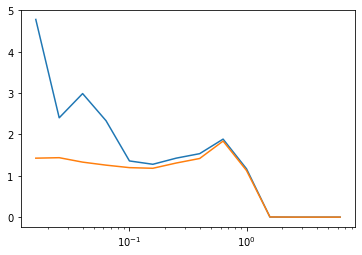

In [631]:
plt.plot(betas[1:-1],D1)
plt.plot(betas[1:-1],D2)
plt.semilogx()

In [603]:
d_recon

array([ 5.63703041e-04,  4.00078716e-04,  1.28683262e-03,  3.92822642e-03,
        4.16803313e-03,  1.00766383e-02,  2.32265294e-02,  7.77572319e-02,
        1.72521800e-01,  7.02267915e-01,  3.42583656e-03,  2.46882439e-04,
       -6.27040863e-05,  1.05977058e-04, -2.22206116e-04])

In [590]:
np.sum(np.sqrt(np.mean(np.square(encoder.predict(valid_data)[0]),axis=0)))

2.7081068

In [584]:
vae.evaluate([valid_data, np.ones(len(valid_data))*beta],valid_data)

10000/10000 [==============================] - 1s 58us/sample - loss: 7.8047 - recon_loss: 1.2619e-04 - kl_loss: 6.5438


[7.804718141174316, 0.00012619405, 6.5438323]

In [577]:
weights_downbeta

['von_mises_linear_beta_0.01_274_weights.hdf5',
 'von_mises_linear_beta_0.015848931924611124_267_weights.hdf5',
 'von_mises_linear_beta_0.025118864315095794_262_weights.hdf5',
 'von_mises_linear_beta_0.03981071705534969_257_weights.hdf5',
 'von_mises_linear_beta_0.0630957344480193_252_weights.hdf5',
 'von_mises_linear_beta_0.1_244_weights.hdf5',
 'von_mises_linear_beta_0.15848931924611134_237_weights.hdf5',
 'von_mises_linear_beta_0.25118864315095796_226_weights.hdf5',
 'von_mises_linear_beta_0.39810717055349715_214_weights.hdf5',
 'von_mises_linear_beta_0.630957344480193_210_weights.hdf5',
 'von_mises_linear_beta_1.0_203_weights.hdf5',
 'von_mises_linear_beta_1.5848931924611134_195_weights.hdf5',
 'von_mises_linear_beta_2.5118864315095797_187_weights.hdf5',
 'von_mises_linear_beta_3.9810717055349722_180_weights.hdf5',
 'von_mises_linear_beta_6.309573444801933_172_weights.hdf5',
 'von_mises_linear_beta_10.0_165_weights.hdf5']

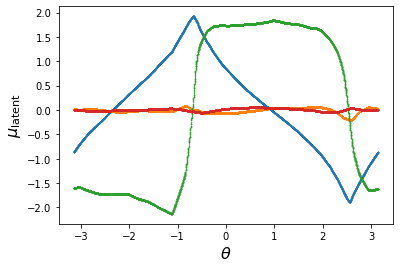

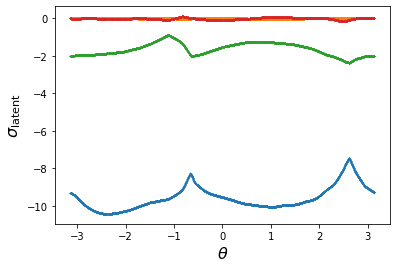

In [579]:
fontsize=16

for dim in range(latent_dims_line):
    plt.scatter(np.arctan2(valid_data[:,0],valid_data[:,1]),encoder.predict(valid_data)[0][:,dim],s=0.1)
plt.xlabel(r"$\theta$",fontsize=fontsize)
plt.ylabel(r"$\mu_\mathrm{latent}$",fontsize=fontsize)
plt.show()

for dim in range(latent_dims_line,latent_dims_circle+latent_dims_line):
    plt.scatter(np.arctan2(valid_data[:,0],valid_data[:,1]),encoder.predict(valid_data)[0][:,dim])
    

plt.show()

for dim in range(latent_dims_line):
    plt.scatter(np.arctan2(valid_data[:,0],valid_data[:,1]),encoder.predict(valid_data)[1][:,dim],s=0.1)
plt.xlabel(r"$\theta$",fontsize=fontsize)
plt.ylabel(r"$\sigma_\mathrm{latent}$",fontsize=fontsize)
plt.show()

for dim in range(latent_dims_line,latent_dims_circle+latent_dims_line):
    plt.scatter(np.arctan2(valid_data[:,0],valid_data[:,1]),encoder.predict(valid_data)[1][:,dim])
plt.show()

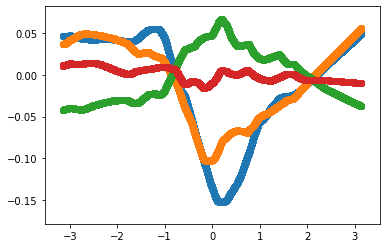

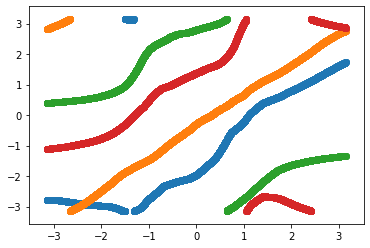

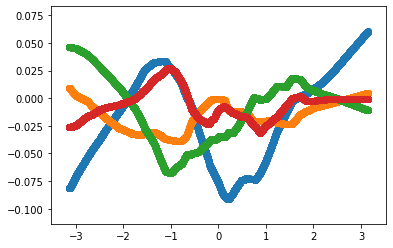

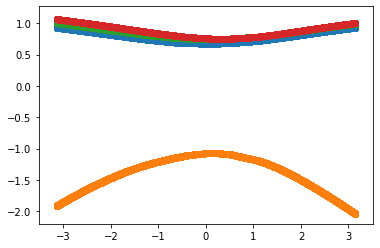

In [500]:
for dim in range(latent_dims_line):
    plt.scatter(valid_theta,encoder.predict(valid_theta)[0][:,dim])
plt.show()

for dim in range(latent_dims_line,latent_dims_circle+latent_dims_line):
    plt.scatter(valid_theta,encoder.predict(valid_theta)[0][:,dim])
plt.show()

for dim in range(latent_dims_line):
    plt.scatter(valid_theta,encoder.predict(valid_theta)[1][:,dim])
plt.show()

for dim in range(latent_dims_line,latent_dims_circle+latent_dims_line):
    plt.scatter(valid_theta,encoder.predict(valid_theta)[1][:,dim])
plt.show()

In [295]:
plt.scatter(np.arctan2(valid_data[:,0],valid_data[:,1]),encoder.predict(valid_data)[0][:,0])
plt.show()
plt.scatter(np.arctan2(valid_data[:,0],valid_data[:,1]),encoder.predict(valid_data)[0][:,1])
plt.show()

ValueError: Error when checking input: expected input_89 to have shape (1,) but got array with shape (2,)

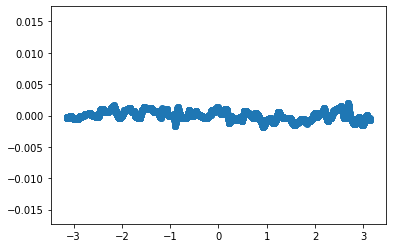

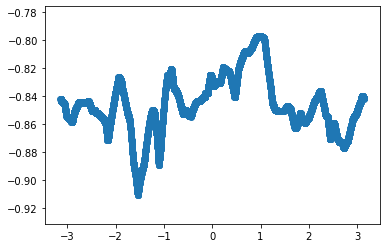

In [65]:
plt.scatter(np.arctan2(valid_data[:,0],valid_data[:,1]),encoder.predict([valid_data,beta_valid])[1][:,0])
plt.show()
plt.scatter(np.arctan2(valid_data[:,0],valid_data[:,1]),encoder.predict([valid_data,beta_valid])[1][:,1])
plt.show()

In [69]:

class encoder_class():
    def __init__(self,encoder):
        self.encoder = encoder
        
    def predict(self, data):
        return self.encoder.predict([data,np.ones(len(data))])

# Beta-VAE experiments

## beta = 0.001
In the limit of small beta, the vae behaves like an AE because the KL term is not given significant weight. It is not to be expected that the latent space directions will be so well behaved.

In [70]:
experiment_name = '2D_banana'
vae, encoder, decoder = build_and_compile_annealing_vae(encoder = [512,256,128,128],
                                                        decoder = [512,256,128,128],
                                                        optimizer=keras.optimizers.Adam(lr=0.001,clipnorm=0.1))



OperatorNotAllowedInGraphError: using a `tf.Tensor` as a Python `bool` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.

In [112]:
reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=1e-5, cooldown=0, min_lr=0)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks = [modelcheckpoint,reduceLR,earlystop]

beta = 0.3
K.set_value(vae.optimizer.lr,1e-4)
epochs = 1000
history = vae.fit(x=[train_data,np.ones(len(train_data))*beta], y=train_data, batch_size=100,
                epochs=epochs,verbose=1,#initial_epoch=history.epoch[-1],
                validation_data = ([valid_data,np.ones(len(valid_data))*beta],valid_data),
                callbacks = callbacks
              )

# tf.saved_model.save(vae, train_output_dir + '/mymodel.hdf5')

Train on 100000 samples, validate on 10000 samples
Epoch 1/1000
100000/100000 [==============================] - 8s 78us/sample - loss: 2.2979 - recon_loss: 0.0564 - get_kl_loss: 1.6718 - val_loss: 2.2188 - val_recon_loss: 0.0602 - val_get_kl_loss: 1.5503
Epoch 2/1000
100000/100000 [==============================] - 7s 73us/sample - loss: 2.2268 - recon_loss: 0.0578 - get_kl_loss: 1.5846 - val_loss: 2.2099 - val_recon_loss: 0.0548 - val_get_kl_loss: 1.6010
Epoch 3/1000
100000/100000 [==============================] - 9s 91us/sample - loss: 2.2178 - recon_loss: 0.0574 - get_kl_loss: 1.5803 - val_loss: 2.2785 - val_recon_loss: 0.0657 - val_get_kl_loss: 1.5483
Epoch 4/1000
100000/100000 [==============================] - 12s 121us/sample - loss: 2.2160 - recon_loss: 0.0570 - get_kl_loss: 1.5823 - val_loss: 2.2036 - val_recon_loss: 0.0566 - val_get_kl_loss: 1.5752
Epoch 5/1000
100000/100000 [==============================] - 9s 87us/sample - loss: 2.2190 - recon_loss: 0.0571 - get_kl_loss:

Latent space encoding for beta = 3.0 :


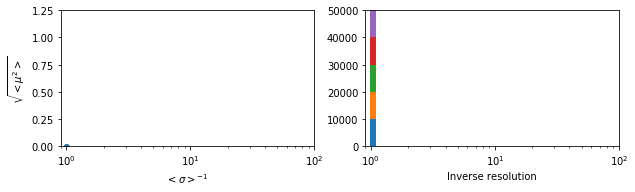

In [94]:
print("Latent space encoding for beta =",beta,":")
myencoder = encoder_class(encoder)
    
plot_latent_space_2(myencoder,valid_data,xrange = [0.9,1e2])

We see from the rightmost plot especially that the latent space is not well regulated. There doesn't seem to be much useful information in the middle plot.

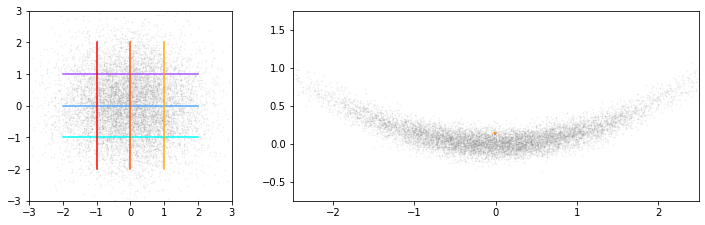

In [95]:
plot_latent_map(myencoder, decoder, valid_data)

In [ ]:
betas = np.array([1e-2,3e-2,6e-2,8e-2,9e-2,1e-1,1.1e-1,1.2e-1,1.4e-1,2e-1,4e-1,6e-1,8e-1,9e-1,1.,1.1,1.2,1.4,1.6,2.,4.])
sigmas = np.zeros(len(betas))
KLs = np.zeros(len(betas))

Train on 100000 samples, validate on 10000 samples
Epoch 1/1000
100000/100000 [==============================] - 9s 85us/sample - loss: 138.3060 - recon_loss: 0.0134 - get_kl_loss: 3.9972 - val_loss: 99.3005 - val_recon_loss: 0.0094 - val_get_kl_loss: 5.0434
Epoch 2/1000
100000/100000 [==============================] - 8s 76us/sample - loss: 96.3089 - recon_loss: 0.0091 - get_kl_loss: 5.4253 - val_loss: 84.1056 - val_recon_loss: 0.0078 - val_get_kl_loss: 6.0385
Epoch 3/1000
100000/100000 [==============================] - 8s 80us/sample - loss: 28.3191 - recon_loss: 0.0021 - get_kl_loss: 7.6697 - val_loss: 10.6487 - val_recon_loss: 2.1974e-04 - val_get_kl_loss: 8.4512
Epoch 4/1000
100000/100000 [==============================] - 7s 75us/sample - loss: 10.1209 - recon_loss: 1.8333e-04 - get_kl_loss: 8.2876 - val_loss: 9.8067 - val_recon_loss: 1.6613e-04 - val_get_kl_loss: 8.1454
Epoch 5/1000
100000/100000 [==============================] - 7s 74us/sample - loss: 9.7883 - recon_loss: 1.6

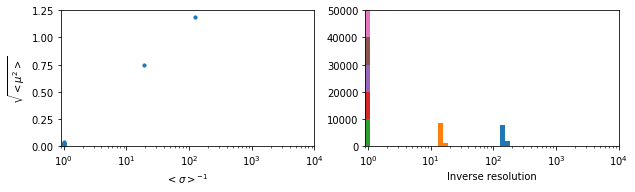

Train on 100000 samples, validate on 10000 samples
Epoch 1/1000
100000/100000 [==============================] - 7s 68us/sample - loss: 6.6990 - recon_loss: 8.3204e-04 - get_kl_loss: 5.7745 - val_loss: 6.5875 - val_recon_loss: 9.6275e-04 - val_get_kl_loss: 5.5177
Epoch 2/1000
100000/100000 [==============================] - 7s 66us/sample - loss: 6.5733 - recon_loss: 9.5592e-04 - get_kl_loss: 5.5112 - val_loss: 6.5356 - val_recon_loss: 9.4726e-04 - val_get_kl_loss: 5.4831
Epoch 3/1000
100000/100000 [==============================] - 7s 67us/sample - loss: 6.5502 - recon_loss: 9.5937e-04 - get_kl_loss: 5.4843 - val_loss: 6.5097 - val_recon_loss: 9.4436e-04 - val_get_kl_loss: 5.4604
Epoch 4/1000
100000/100000 [==============================] - 7s 68us/sample - loss: 6.5297 - recon_loss: 9.6180e-04 - get_kl_loss: 5.4611 - val_loss: 6.5095 - val_recon_loss: 9.7173e-04 - val_get_kl_loss: 5.4298
Epoch 5/1000
 99500/100000 [============================>.] - ETA: 0s - loss: 6.5169 - recon_loss

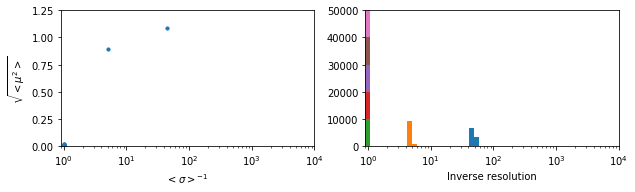

Train on 100000 samples, validate on 10000 samples
Epoch 1/1000
100000/100000 [==============================] - 9s 89us/sample - loss: 5.0986 - recon_loss: 0.0035 - get_kl_loss: 4.1331 - val_loss: 5.0874 - val_recon_loss: 0.0038 - val_get_kl_loss: 4.0276
Epoch 2/1000
100000/100000 [==============================] - 8s 83us/sample - loss: 5.0581 - recon_loss: 0.0037 - get_kl_loss: 4.0222 - val_loss: 5.0473 - val_recon_loss: 0.0037 - val_get_kl_loss: 4.0104
Epoch 3/1000
100000/100000 [==============================] - 7s 69us/sample - loss: 5.0593 - recon_loss: 0.0037 - get_kl_loss: 4.0251 - val_loss: 5.0439 - val_recon_loss: 0.0037 - val_get_kl_loss: 4.0137
Epoch 4/1000
100000/100000 [==============================] - 7s 73us/sample - loss: 5.0592 - recon_loss: 0.0037 - get_kl_loss: 4.0188 - val_loss: 5.0384 - val_recon_loss: 0.0037 - val_get_kl_loss: 4.0065
Epoch 5/1000
100000/100000 [==============================] - 7s 75us/sample - loss: 5.0510 - recon_loss: 0.0037 - get_kl_loss: 4

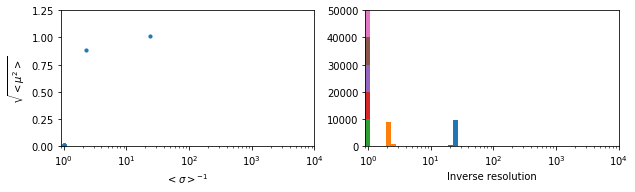

In [113]:


for i, beta in enumerate(betas[:3]):
    min_delta=1e-6/beta**2
    reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=min_delta, cooldown=0, min_lr=0)
    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callbacks = [modelcheckpoint,reduceLR,earlystop]

    K.set_value(vae.optimizer.lr,1e-5)
    epochs = 1000
    history = vae.fit(x=[train_data,np.ones(len(train_data))*beta], y=train_data, batch_size=100,
                    epochs=epochs,verbose=1,#initial_epoch=history.epoch[-1],
                    validation_data = ([valid_data,np.ones(len(valid_data))*beta],valid_data),
                    callbacks = callbacks
                  )
    
    KLs[i] = history.history['val_get_kl_loss'][-1]    
    sigmas[i] = history.history['val_recon_loss'][-1]
    
    print("Latent space encoding for beta =",beta,":")
    myencoder = encoder_class(encoder)

    plot_latent_space_2(myencoder,valid_data,xrange = [0.9,1e4])

In [114]:
print(betas)
print(sigmas)
print(KLs)

[0.01 0.03 0.06 0.08 0.09 0.1  0.11 0.12 0.14 0.2  0.4  0.6  0.8  0.9
 1.   1.1  1.2  1.4  1.6  2.   4.  ]
[1.23999125e-04 9.39664547e-04 3.71434353e-03 6.50330074e-03
 8.34107958e-03 1.02508962e-02 1.23275183e-02 1.42117683e-02
 1.85486358e-02 2.93094274e-02 8.98161680e-02 1.88243061e-01
 3.39374542e-01 4.20717537e-01 5.17438114e-01 6.28636539e-01
 7.39068985e-01 9.99548316e-01 1.03671110e+00 1.03710449e+00
 1.03717279e+00]
[7.76242065e+00 5.43048573e+00 4.00893497e+00 3.42941928e+00
 3.19269085e+00 2.97674775e+00 2.79138064e+00 2.63793397e+00
 2.39459085e+00 1.98806262e+00 1.28814316e+00 8.84745121e-01
 5.87832034e-01 4.69981313e-01 3.64879310e-01 2.61341304e-01
 1.73468307e-01 1.87189057e-02 3.00556676e-05 9.84759390e-06
 2.04966977e-06]


In [ ]:
betas = [0.01 0.03 0.06 0.08 0.09 0.1  0.11 0.12 0.14 0.2  0.4  0.6  0.8  0.9
 1.   1.1  1.2  1.4  1.6  2.   4.  ]

In [115]:
delta_sigmas = np.array([sigmas[i+1] - sigmas[i] for i in range(len(sigmas)-1)])
delta_betasqrs = np.array([betas[i+1]**2 - betas[i]**2 for i in range(len(sigmas)-1)])
delta_KLs = np.array([KLs[i+1] - KLs[i] for i in range(len(sigmas)-1)])
delta_log_betas = np.array([2*np.log(betas[i+1]/betas[i]) for i in range(len(betas) - 1)])

NameError: name 'betas' is not defined

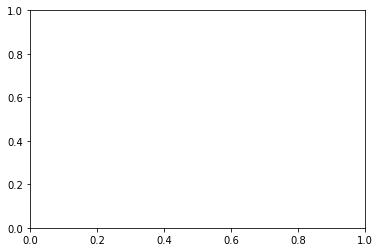

In [47]:
fig,ax = plt.subplots()
ax.plot(betas[:-1],delta_sigmas/delta_betasqrs*2)
ax.plot(betas[:-1],-delta_KLs/delta_log_betas*2)
ax.plot(scales[:-1],corr_dim)
ax.semilogx()
ax.set_xlabel(r"Length Scale")
ax.set_ylabel("Dimensionality")
plt.show()

The VAE is behaving like an AE. The NN has learnt some mapping between the latent space and the real space, but it is random and arbitrary. 

## beta = 0.01

In [155]:
experiment_name = '2D-VAE-beta0.01'
vae, encoder, decoder = build_and_compile_vae(beta=0.01,
                                              encoder=[256,128,64,64,32],
                                              decoder=[256,128,64,64,32],
                                             optimizer=keras.optimizers.Adam(lr=0.001))

save_period = 10
epochs = 20

train_output_dir = create_dir(osp.join(output_dir, experiment_name))
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_{epoch:02d}-{val_loss:.2e}.hdf5', period = save_period)

callbacks = [modelcheckpoint]

history = vae.fit(x=train_data, y=train_data, batch_size=100,
                epochs=epochs,verbose=1,
                validation_data = (valid_data,valid_data),
                callbacks = callbacks
              )

Train on 100000 samples, validate on 10000 samples
Epoch 1/20
100000/100000 [==============================] - 19s 188us/step - loss: 0.1375 - val_loss: 0.1152
Epoch 2/20
100000/100000 [==============================] - 12s 123us/step - loss: 0.1067 - val_loss: 0.1050
Epoch 3/20
100000/100000 [==============================] - 12s 122us/step - loss: 0.1064 - val_loss: 0.1109
Epoch 4/20
100000/100000 [==============================] - 12s 123us/step - loss: 0.1057 - val_loss: 0.1052
Epoch 5/20
100000/100000 [==============================] - 12s 122us/step - loss: 0.1051 - val_loss: 0.1048
Epoch 6/20
100000/100000 [==============================] - 12s 123us/step - loss: 0.1053 - val_loss: 0.1037
Epoch 7/20
100000/100000 [==============================] - 12s 123us/step - loss: 0.1051 - val_loss: 0.1026
Epoch 8/20
100000/100000 [==============================] - 12s 122us/step - loss: 0.1044 - val_loss: 0.1067
Epoch 9/20
100000/100000 [==============================] - 12s 123us/step - 

Latent space encoding for beta = 0.01:


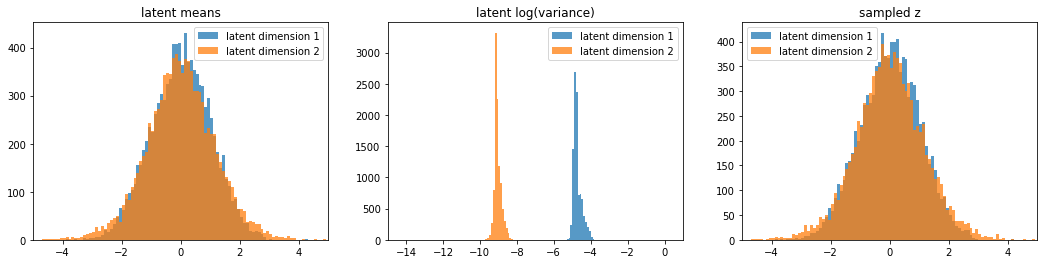

In [158]:
print("Latent space encoding for beta = 0.01:")
plot_latent_space(encoder,valid_data)

Latent space mapping for beta = 0.01:


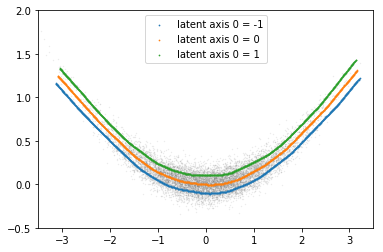

In [159]:
print("Latent space mapping for beta = 0.01:")
plot_latent_map(decoder,valid_data,long_axis=1)

The VAE is well regulated, and the two latent space axes represent the two principal directions of variation in the data. There are two sharp peaks in the plot of log(variance) of the latent variables, and -9, and -5. These latent axes correspond to the long and short directions of the banana respectively. The locations of these peaks are very meaningful. There is a relation that can be deduced from inspection of the loss function. If there is a well defined length scale in the real space problem, then this will be encoded in a latent direction with variance given by L = beta / sigma, where L is the length scale, beta is the KL weight and sigma is sqrt of the variance. The peaks at around -9 and -5 map to L - 1 and 0.1 respectively. We can deduce from that that the orange latent dimension (dimension 1) corresponds to the length of the banan (which has size of order 1) while latent dimension 0 will correspond with the girth of the banana that has characteristic size of 0.1. This is established in the play above which maps the latent directions into real space.

It is therefore possible to do spectroscopy of the lengthscales in the problem by looking for peaks in the distribution of variances. At least it is true in this simple toy example.

A dimension becomes marginal when it is being encoded with log var ~ -1. At this point the VAE is barely able to resolve the dimension. From the plot of log variance above, I deduce that the girth of the banana will become marginal at around beta = 0.01*exp(4/2) ~ 1.

## beta = 0.1

In [160]:
experiment_name = '2D-VAE-beta0.1'
vae, encoder, decoder = build_and_compile_vae(beta=0.1,
                                              encoder=[256,128,64,64,32],
                                              decoder=[256,128,64,64,32],
                                             optimizer=keras.optimizers.Adam(lr=0.001))

save_period = 10
epochs = 20

train_output_dir = create_dir(osp.join(output_dir, experiment_name))
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_{epoch:02d}-{val_loss:.2e}.hdf5', period = save_period)

callbacks = [modelcheckpoint]

history = vae.fit(x=train_data, y=train_data, batch_size=100,
                epochs=epochs,verbose=1,
                validation_data = (valid_data,valid_data),
                callbacks = callbacks
              )

Train on 100000 samples, validate on 10000 samples
Epoch 1/20
100000/100000 [==============================] - 19s 189us/step - loss: 0.2783 - val_loss: 0.2472
Epoch 2/20
100000/100000 [==============================] - 12s 124us/step - loss: 0.2464 - val_loss: 0.2462
Epoch 3/20
100000/100000 [==============================] - 12s 122us/step - loss: 0.2453 - val_loss: 0.2416
Epoch 4/20
100000/100000 [==============================] - 13s 125us/step - loss: 0.2445 - val_loss: 0.2458
Epoch 5/20
100000/100000 [==============================] - 12s 123us/step - loss: 0.2443 - val_loss: 0.2426
Epoch 6/20
100000/100000 [==============================] - 12s 122us/step - loss: 0.2441 - val_loss: 0.2460
Epoch 7/20
100000/100000 [==============================] - 12s 123us/step - loss: 0.2435 - val_loss: 0.2444
Epoch 8/20
100000/100000 [==============================] - 12s 124us/step - loss: 0.2436 - val_loss: 0.2431
Epoch 9/20
100000/100000 [==============================] - 13s 125us/step - 

Latent space encoding for beta = 0.1:


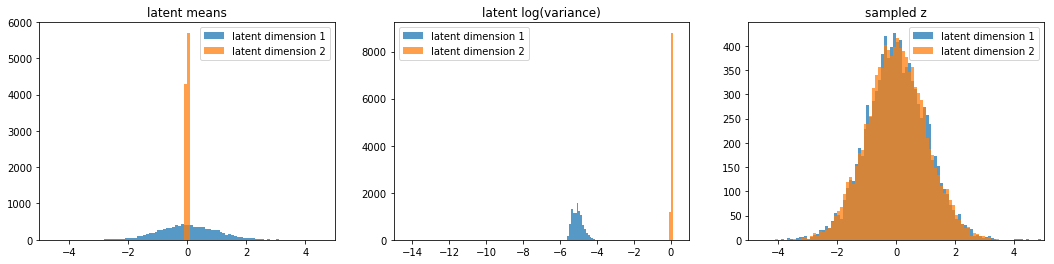

In [161]:
print("Latent space encoding for beta = 0.1:")
plot_latent_space(encoder,valid_data)

Latent space mapping for beta = 0.1:


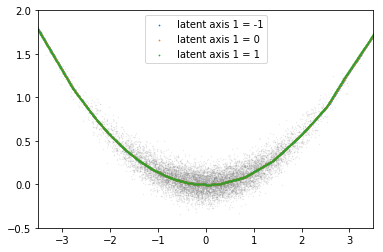

In [163]:
print("Latent space mapping for beta = 0.1:")
plot_latent_map(decoder,valid_data,long_axis=0)

It looks like the girth can no longer be resolved. It should still be resolvable though. The ratio in the sizes of the two dimensions is a factor 10. In the variance plot, blue peaks at -5, so orange should peak at -5 + Log(100) = -0.5, but instead it has been completely pushed to 0. All points are being decoded to an average value along the girth, but still have some prediction along the length.

Actually, this is a consequence of falling in a bad local minimum. There is frequently a local minumum when a latent space variable encodes nothing (satisfying the KL term), and it seems to be very difficult to escape from. I actually had to train the beta = 0.01 example many times, since it would frequently not learn the girth. I will show later that the girth is still barely resolvable at beta = 0.1 using beta-annealing.

## beta = 1

In [66]:
experiment_name = '2D-VAE-beta1'
vae, encoder, decoder = build_and_compile_vae(beta=1.,
                                              encoder=[256,128,64,64,32],
                                              decoder=[256,128,64,64,32],
                                             optimizer=keras.optimizers.Adam(lr=0.001))

save_period = 10
epochs = 10

train_output_dir = create_dir(osp.join(output_dir, experiment_name))
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_{epoch:02d}-{val_loss:.2e}.hdf5', period = save_period)

callbacks = [modelcheckpoint]

history = vae.fit(x=train_data, y=train_data, batch_size=100,
                epochs=epochs,verbose=1,
                validation_data = (valid_data,valid_data),
                callbacks = callbacks
              )

Train on 100000 samples, validate on 10000 samples
Epoch 1/10
100000/100000 [==============================] - 17s 166us/step - loss: 0.7658 - val_loss: 0.7630
Epoch 2/10
100000/100000 [==============================] - 12s 122us/step - loss: 0.7568 - val_loss: 0.7556
Epoch 3/10
100000/100000 [==============================] - 12s 123us/step - loss: 0.7561 - val_loss: 0.7597
Epoch 4/10
100000/100000 [==============================] - 12s 121us/step - loss: 0.7573 - val_loss: 0.7566
Epoch 5/10
100000/100000 [==============================] - 12s 122us/step - loss: 0.7560 - val_loss: 0.7628
Epoch 6/10
100000/100000 [==============================] - 12s 121us/step - loss: 0.7525 - val_loss: 0.7582
Epoch 7/10
100000/100000 [==============================] - 12s 122us/step - loss: 0.7563 - val_loss: 0.7551
Epoch 8/10
100000/100000 [==============================] - 12s 121us/step - loss: 0.7559 - val_loss: 0.7593
Epoch 9/10
100000/100000 [==============================] - 12s 123us/step - 

Latent space encoding for beta = 1:


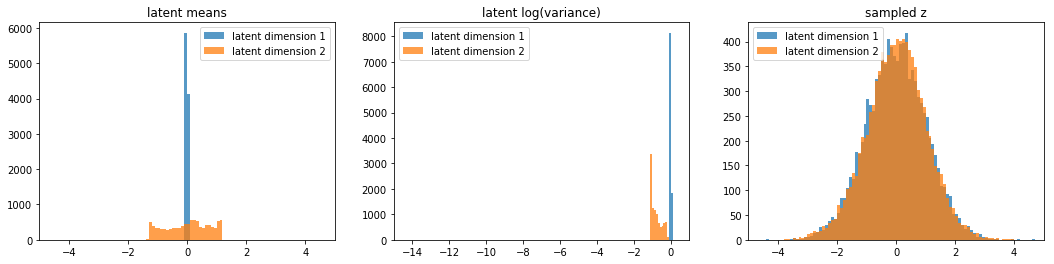

In [67]:
print("Latent space encoding for beta = 1:")
plot_latent_space(encoder,valid_data)

beta = 1


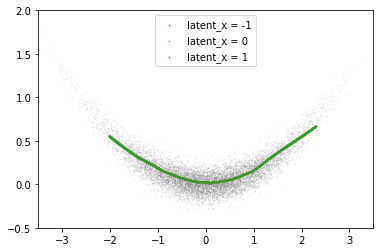

In [68]:
print("beta = 1")
plot_latent_map(decoder,valid_data,long_axis=1)

The short dimension is long gone and the long dimension is becoming marginal. The resolution in the long direction is O(1) and all points are being mapped to an average location along the girth.

## beta = 3

In [72]:
experiment_name = '2D-VAE-beta3'
vae, encoder, decoder = build_and_compile_vae(beta=3.,
                                              encoder=[256,128,64,64,32],
                                              decoder=[256,128,64,64,32],
                                             optimizer=keras.optimizers.Adam(lr=0.001))

save_period = 10
epochs = 10

train_output_dir = create_dir(osp.join(output_dir, experiment_name))
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_{epoch:02d}-{val_loss:.2e}.hdf5', period = save_period)

callbacks = [modelcheckpoint]

history = vae.fit(x=train_data, y=train_data, batch_size=100,
                epochs=epochs,verbose=1,
                validation_data = (valid_data,valid_data),
                callbacks = callbacks
              )

Train on 100000 samples, validate on 10000 samples
Epoch 1/10
100000/100000 [==============================] - 17s 168us/step - loss: 0.8272 - val_loss: 0.8264
Epoch 2/10
100000/100000 [==============================] - 12s 122us/step - loss: 0.8220 - val_loss: 0.8270
Epoch 3/10
100000/100000 [==============================] - 12s 122us/step - loss: 0.8218 - val_loss: 0.8270
Epoch 4/10
100000/100000 [==============================] - 12s 123us/step - loss: 0.8218 - val_loss: 0.8269
Epoch 5/10
100000/100000 [==============================] - 12s 122us/step - loss: 0.8219 - val_loss: 0.8272
Epoch 6/10
100000/100000 [==============================] - 12s 123us/step - loss: 0.8217 - val_loss: 0.8264
Epoch 7/10
100000/100000 [==============================] - 12s 121us/step - loss: 0.8216 - val_loss: 0.8266
Epoch 8/10
100000/100000 [==============================] - 12s 123us/step - loss: 0.8215 - val_loss: 0.8264
Epoch 9/10
100000/100000 [==============================] - 12s 123us/step - 

Latent space encoding for beta = 1:


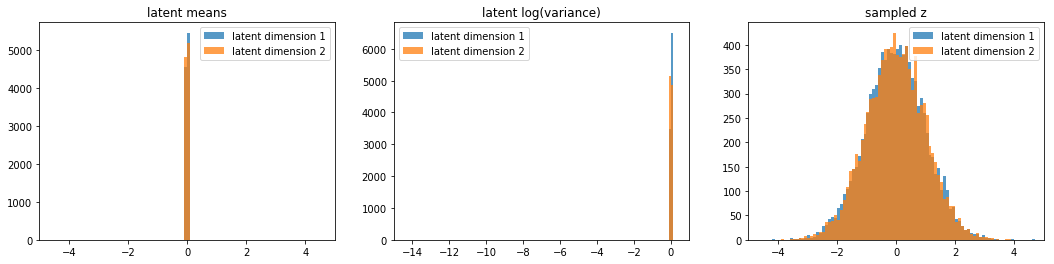

In [73]:
print("Latent space encoding for beta = 1:")
plot_latent_space(encoder,valid_data)

beta = 1


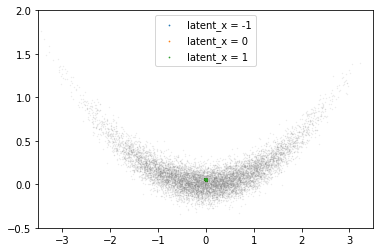

In [74]:
print("beta = 1")
plot_latent_map(decoder,valid_data,long_axis=1)

The long dimension is now also unresolvable. The encoder chooses to encode no information about the input into the latent space. The decoder has learnt to ignore the latent space, and to map everything to an average point in the real space.

### Commentary

Beta sets the resolution for the VAE, and the VAE may not resolve information below the scale set by beta. So for beta above 0.1, the VAE cannot resolve the dimension with typical size 0.1. For beta above 1, it cannot resolve the dimension with typical size 1.

For very small beta (compared to the length scales of interest), the VAE behaves like an AE. It encodes all the information it can into the latent space, but in a way that is not regulated and is difficult to interpret. As beta becomes marginal for some axes of variation, some latent space dimensions begin to align with those axes. If the length scales are sharp (as they are in this toy dataset), the distribution of encoded variances forms a peak that maps directly to the corresponding length scale, allowing you to perform spectroscopy.

The latent space should be as large as possible. It is beta that forces a dimensional reduction. For 0.1 < beta < 1, the latent space was in principle 2D, but it was clear that only one of them was encoding information. By using beta instead of the number of latent dimensions to control the dimensional reduction, we are encouraging the VAE to organise information hierarchically according to importance (where importance is defined only with respect to that metric that is used for defining the reconstruction loss).

When beta is marginal, it becomes very difficult to train the VAE as it falls into local minima where it is discarding information that would actually be encoded in the global minimum. This is fixed with beta annealing below

# Beta annealing

The idea is to start training at very small beta, so the VAE learns to encode a poorly regulated but high-information encoding of the information into the latent space. As you then increase beta, the latent directions become well regulated and begin to align with axes of variance present in the training dataset. Dimensions will only be forgetten when beta truly crosses over the threshold of marginality.

In [118]:
def build_and_compile_annealing_vae(encoder = [512,256,128,64,32],
                                    decoder = [512,256,128,64,32],
                                    verbose=0,dropout=0,
                                    optimizer=keras.optimizers.Adam()):
    
    def sampling(args):
        """Reparameterization trick by sampling fr an isotropic unit Gaussian.

        # Arguments
            args (tensor): mean and log of variance of Q(z|X)

        # Returns
            z (tensor): sampled latent vector
        """

        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    latent_dim = 2
    #Encoder
    inputs = tf.keras.Input(shape=(2,))
    beta_input = tf.keras.Input(shape=(1,))
#     layer = inputs
    layer = tf.keras.layers.Concatenate()([inputs,beta_input])
    layer = Lambda(lambda x: x[:,:2])(layer)
    for layer_size in encoder:
        layer = Dense(layer_size,bias_initializer='glorot_uniform')(layer)
        layer = keras.layers.ReLU()(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)
        

    #Bottleneck
    z_mean = Dense(latent_dim, name='z_mean')(layer)
    z_log_var = Dense(latent_dim, name='z_log_var')(layer)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = Model([inputs,beta_input], [z_mean, z_log_var, z], name='encoder')
    if verbose:
        encoder.summary()
    #plot_model(encoder, to_file='CNN-VAE_encoder.png', show_shapes=True)

    #Decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    layer = latent_inputs
    
    for layer_size in decoder:
        layer = Dense(layer_size,bias_initializer='glorot_uniform')(layer)
        layer = keras.layers.ReLU()(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)
            
    decoded = Dense(2)(layer)

    decoder = Model(latent_inputs, decoded, name='decoder')
    if verbose:
        decoder.summary()
    #plot_model(decoder, to_file='CNN-VAE_decoder.png', show_shapes=True)


    outputs = decoder(encoder([inputs,beta_input])[2])
    vae = Model([inputs,beta_input], outputs, name='CNN-VAE')

    def beta_vae_loss(beta):
        def vae_loss(x, x_decoded_mean):
            xent_loss = K.sqrt(K.sum(K.square(x - x_decoded_mean),axis=-1))
            kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            return K.mean(xent_loss + beta * kl_loss)
        return vae_loss
    
    def recon_loss(x, x_decoded_mean):
        recon_loss = K.sqrt(K.sum(K.square(x - x_decoded_mean),axis=-1))
        return K.mean(recon_loss)
    
    def kl_loss(beta):
        def get_kl_loss(x, x_decoded_mean):
            kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            return K.mean( beta * kl_loss)
        return get_kl_loss
    
    vae.compile(loss=beta_vae_loss(beta_input),
                optimizer=optimizer,
                metrics = [recon_loss,kl_loss(beta_input)]
               )
    
    vae.summary()
    
    return vae, encoder, decoder

save_period = 10
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_{epoch:02d}-{val_loss:.2e}.hdf5', period = save_period)
reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=6, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

callbacks = [modelcheckpoint,reduceLR,earlystop]

class encoder_class():
    def __init__(self,encoder):
        self.encoder = encoder
        
    def predict(self, data):
        return self.encoder.predict([data,np.ones(len(data))])

In [119]:
experiment_name = '2D-VAE-beta-anneal'
vae, encoder, decoder = build_and_compile_annealing_vae(encoder=[256,128,64,64,32],
                                                        decoder=[256,128,64,64,32],
                                                        optimizer=keras.optimizers.Adam(lr=0.001))



Model: "CNN-VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_68 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_69 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 48292       input_68[0][0]                   
                                                                 input_69[0][0]                   
__________________________________________________________________________________________________
decoder (Model)                 (None, 2)            48226       encoder[1][2]              

In [120]:
beta = 0.0001
epochs = 50
history = vae.fit(x=[train_data,np.ones(len(train_data))*beta], y=train_data, batch_size=100,
                epochs=epochs,verbose=1,
                validation_data = ([valid_data,np.ones(len(valid_data))*beta],valid_data),
                callbacks = callbacks
              )

# tf.saved_model.save(vae, train_output_dir + '/mymodel.hdf5')

Train on 100000 samples, validate on 10000 samples
Epoch 1/50
100000/100000 [==============================] - 19s 189us/sample - loss: 0.1094 - get_xent_loss: 0.1083 - get_kl_loss: 0.0011 - val_loss: 0.0866 - val_get_xent_loss: 0.0855 - val_get_kl_loss: 0.0011
Epoch 2/50
100000/100000 [==============================] - 15s 147us/sample - loss: 0.0819 - get_xent_loss: 0.0809 - get_kl_loss: 0.0010 - val_loss: 0.0811 - val_get_xent_loss: 0.0801 - val_get_kl_loss: 9.9846e-04
Epoch 3/50
100000/100000 [==============================] - 16s 157us/sample - loss: 0.0516 - get_xent_loss: 0.0501 - get_kl_loss: 0.0014 - val_loss: 0.0213 - val_get_xent_loss: 0.0196 - val_get_kl_loss: 0.0017
Epoch 4/50
100000/100000 [==============================] - 15s 147us/sample - loss: 0.0200 - get_xent_loss: 0.0182 - get_kl_loss: 0.0017 - val_loss: 0.0113 - val_get_xent_loss: 0.0096 - val_get_kl_loss: 0.0017
Epoch 5/50
100000/100000 [==============================] - 14s 142us/sample - loss: 0.0166 - get_xen

KeyboardInterrupt: 

Latent space encoding for beta = 0.0001 :


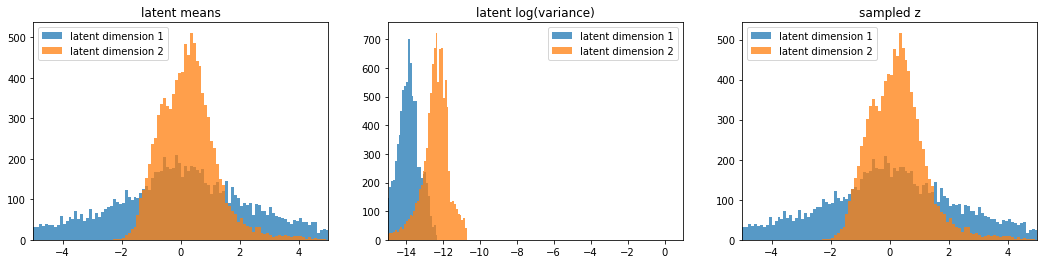

In [121]:
print("Latent space encoding for beta =",beta,":")


myencoder = encoder_class(encoder)
    
plot_latent_space(myencoder,valid_data)

Latent space mapping for beta =  0.0001 :


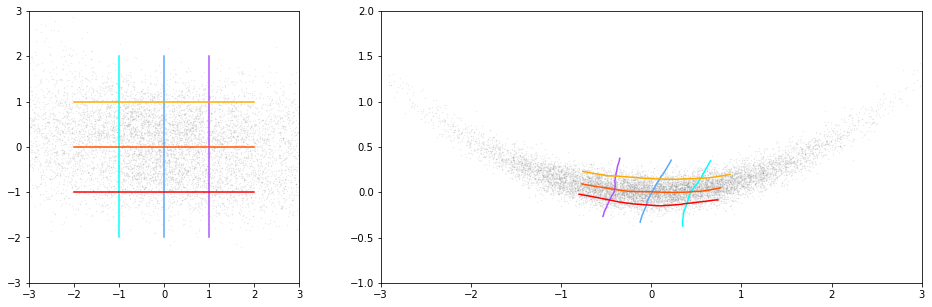

In [122]:
print("Latent space mapping for beta = ",beta,":")
plot_latent_map(myencoder,decoder,valid_data,long_axis=0)

In [143]:
beta = 0.001
K.set_value(vae.optimizer.lr,1e-3)
epochs = 50
history = vae.fit(x=[train_data,np.ones(len(train_data))*beta], y=train_data, batch_size=100,
                epochs=epochs,verbose=1,initial_epoch=history.epoch[-1],
                validation_data = ([valid_data,np.ones(len(valid_data))*beta],valid_data),
                callbacks = callbacks
              )

# tf.saved_model.save(vae, train_output_dir + '/mymodel.hdf5')

Train on 100000 samples, validate on 10000 samples
Epoch 7/50
100000/100000 [==============================] - 16s 158us/sample - loss: 0.0259 - get_xent_loss: 0.0153 - get_kl_loss: 0.0106 - val_loss: 0.0194 - val_get_xent_loss: 0.0095 - val_get_kl_loss: 0.0100
Epoch 8/50
100000/100000 [==============================] - 15s 151us/sample - loss: 0.0216 - get_xent_loss: 0.0115 - get_kl_loss: 0.0101 - val_loss: 0.0219 - val_get_xent_loss: 0.0122 - val_get_kl_loss: 0.0098
Epoch 9/50
100000/100000 [==============================] - 16s 159us/sample - loss: 0.0203 - get_xent_loss: 0.0103 - get_kl_loss: 0.0100 - val_loss: 0.0201 - val_get_xent_loss: 0.0103 - val_get_kl_loss: 0.0099
Epoch 10/50
100000/100000 [==============================] - 15s 153us/sample - loss: 0.0205 - get_xent_loss: 0.0107 - get_kl_loss: 0.0098 - val_loss: 0.0170 - val_get_xent_loss: 0.0071 - val_get_kl_loss: 0.0099
Epoch 11/50
100000/100000 [==============================] - 14s 136us/sample - loss: 0.0201 - get_xent_

Latent space encoding for beta = 0.01 :


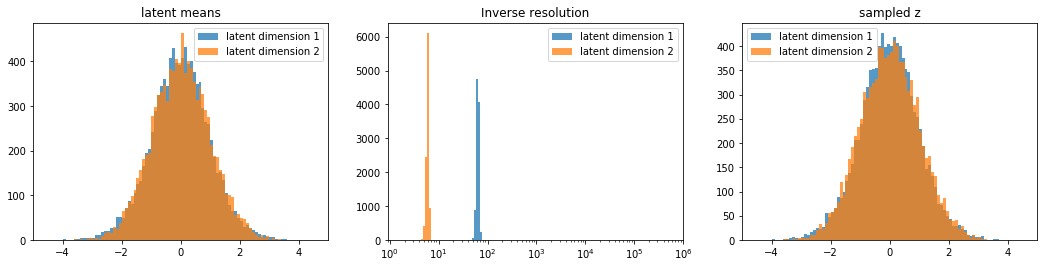

In [181]:
print("Latent space encoding for beta =",beta,":")
myencoder = encoder_class(encoder)
    
plot_latent_space(myencoder,valid_data)

Latent space mapping for beta =  0.01 :


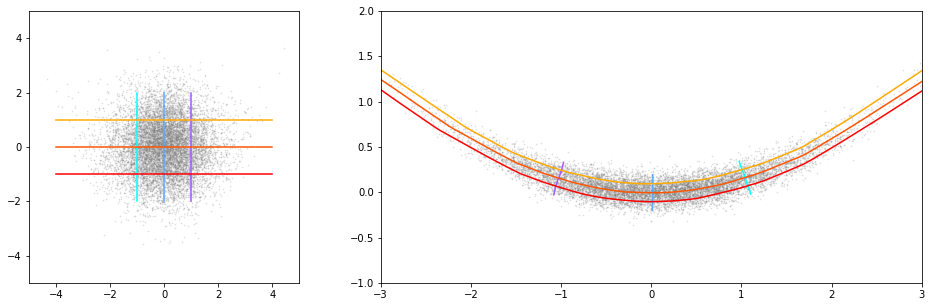

In [182]:
print("Latent space mapping for beta = ",beta,":")
plot_latent_map(myencoder,decoder,valid_data,scales = np.array([[-2,2],[-4,4]]),latent_plotrange = [-5,5])

The latent space is starting to become regulated, as can be seen manifested in all five plots above. Maybe it would have been even better if I trained for more than one epoch.

### beta = 0.01

Increase by a factor of only 3 this time because it is starting to get interesting

In [162]:
beta = 0.01
K.set_value(vae.optimizer.lr,1e-3)
epochs = 50
history = vae.fit(x=[train_data,np.ones(len(train_data))*beta], y=train_data, batch_size=100,
                epochs=epochs,verbose=1,initial_epoch=history.epoch[-1],
                validation_data = ([valid_data,np.ones(len(valid_data))*beta],valid_data),
                callbacks = callbacks
              )

# tf.saved_model.save(vae, train_output_dir + '/mymodel.hdf5')

Train on 100000 samples, validate on 10000 samples
Epoch 40/50
100000/100000 [==============================] - 8s 83us/sample - loss: 0.0837 - get_xent_loss: 0.0263 - get_kl_loss: 0.0574 - val_loss: 0.0823 - val_get_xent_loss: 0.0251 - val_get_kl_loss: 0.0572
Epoch 41/50
100000/100000 [==============================] - 8s 79us/sample - loss: 0.0840 - get_xent_loss: 0.0269 - get_kl_loss: 0.0571 - val_loss: 0.0814 - val_get_xent_loss: 0.0232 - val_get_kl_loss: 0.0582
Epoch 42/50
100000/100000 [==============================] - 8s 80us/sample - loss: 0.0836 - get_xent_loss: 0.0262 - get_kl_loss: 0.0573 - val_loss: 0.0817 - val_get_xent_loss: 0.0237 - val_get_kl_loss: 0.0580
Epoch 43/50
100000/100000 [==============================] - 8s 81us/sample - loss: 0.0836 - get_xent_loss: 0.0263 - get_kl_loss: 0.0573 - val_loss: 0.0817 - val_get_xent_loss: 0.0234 - val_get_kl_loss: 0.0583
Epoch 44/50
100000/100000 [==============================] - 8s 77us/sample - loss: 0.0836 - get_xent_loss: 0

Latent space encoding for beta = 0.01 :


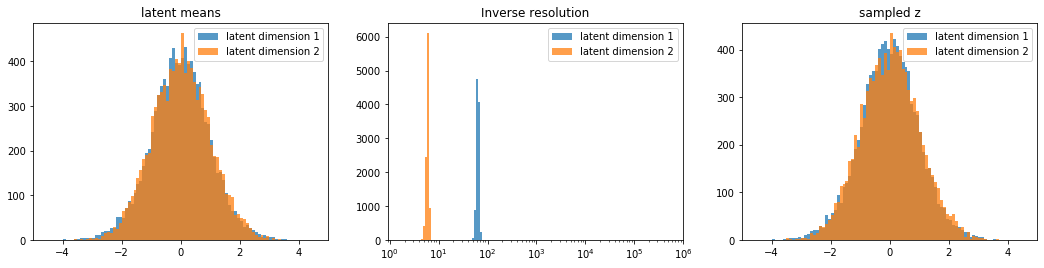

In [183]:
print("Latent space encoding for beta =",beta,":")
myencoder = encoder_class(encoder)
    
plot_latent_space(myencoder,valid_data)

Latent space mapping for beta =  0.01 :


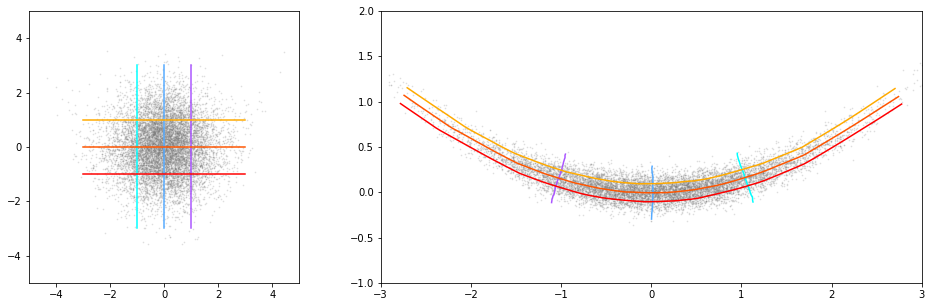

In [184]:
print("Latent space mapping for beta = ",beta,":")
plot_latent_map(myencoder,decoder,valid_data,scales = np.array([[-3,3],[-3,3]]),latent_plotrange = [-5,5])

In [188]:
beta = 0.03
K.set_value(vae.optimizer.lr,1e-3)
epochs = history.epoch[-1] + 50
history = vae.fit(x=[train_data,np.ones(len(train_data))*beta], y=train_data, batch_size=100,
                epochs=epochs,verbose=1,initial_epoch=history.epoch[-1],
                validation_data = ([valid_data,np.ones(len(valid_data))*beta],valid_data),
                callbacks = callbacks
              )

# tf.saved_model.save(vae, train_output_dir + '/mymodel.hdf5')

Train on 100000 samples, validate on 10000 samples
Epoch 50/99
100000/100000 [==============================] - 8s 79us/sample - loss: 0.1770 - get_xent_loss: 0.0684 - get_kl_loss: 0.1087 - val_loss: 0.1745 - val_get_xent_loss: 0.0649 - val_get_kl_loss: 0.1095
Epoch 51/99
100000/100000 [==============================] - 8s 76us/sample - loss: 0.1764 - get_xent_loss: 0.0671 - get_kl_loss: 0.1093 - val_loss: 0.1775 - val_get_xent_loss: 0.0693 - val_get_kl_loss: 0.1082
Epoch 52/99
100000/100000 [==============================] - 8s 76us/sample - loss: 0.1765 - get_xent_loss: 0.0671 - get_kl_loss: 0.1095 - val_loss: 0.1745 - val_get_xent_loss: 0.0658 - val_get_kl_loss: 0.1087
Epoch 53/99
100000/100000 [==============================] - 8s 76us/sample - loss: 0.1766 - get_xent_loss: 0.0674 - get_kl_loss: 0.1091 - val_loss: 0.1764 - val_get_xent_loss: 0.0673 - val_get_kl_loss: 0.1091
Epoch 54/99
 99900/100000 [============================>.] - ETA: 0s - loss: 0.1766 - get_xent_loss: 0.0675 -

Latent space encoding for beta = 0.03 :


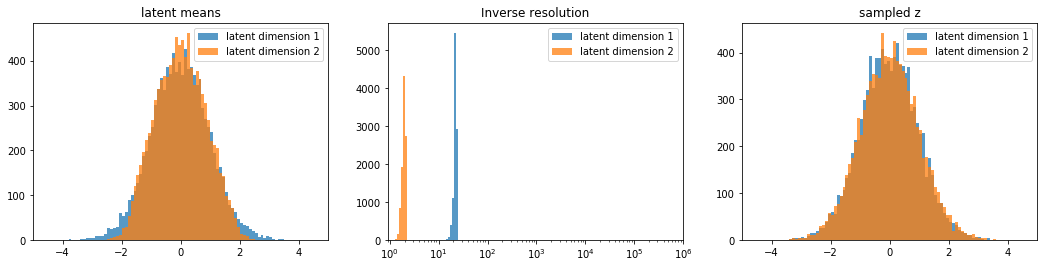

In [189]:
print("Latent space encoding for beta =",beta,":")
myencoder = encoder_class(encoder)
    
plot_latent_space(myencoder,valid_data)

Latent space mapping for beta =  0.03 :


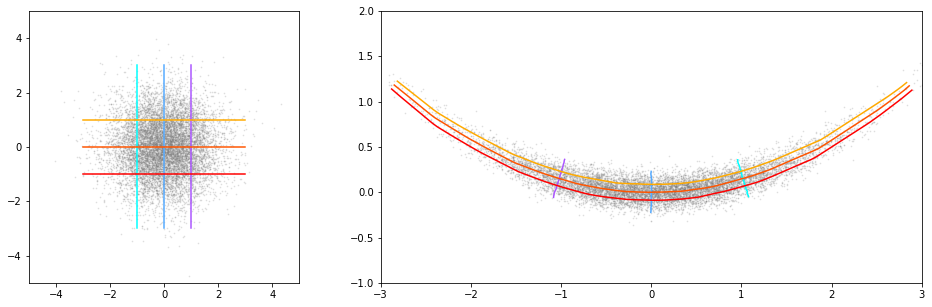

In [190]:
print("Latent space mapping for beta = ",beta,":")
plot_latent_map(myencoder,decoder,valid_data,scales = np.array([[-3,3],[-3,3]]),latent_plotrange = [-5,5])

In [209]:
valid_data_mat = np.tile(valid_data.reshape(len(valid_data),1,2),[1,len(valid_data),1])

In [249]:
train_data_mat = np.tile(train_data.reshape(len(train_data),1,2),[1,len(train_data),1])

MemoryError: Unable to allocate 149. GiB for an array with shape (10000000000, 2) and data type float64

In [213]:
distmat = np.linalg.norm(valid_data_mat - np.transpose(valid_data_mat,[1,0,2]),axis=-1)

In [233]:
Qs = np.logspace(-3,1,100)

In [234]:
numinsphere = [np.mean(np.sum(distmat<dist,axis=-1),axis=-1) for dist in Qs]

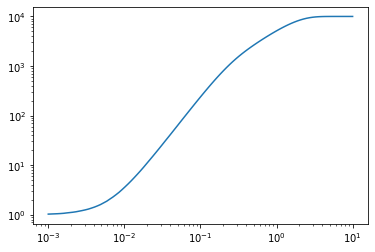

In [235]:
plt.plot(Qs,numinsphere)
plt.semilogx()
plt.semilogy()
plt.show()

In [236]:
derivative = [np.log(numinsphere[i+1]/numinsphere[i])/np.log(Qs[i+1]/Qs[i]) for i in range(len(Qs)-1)]

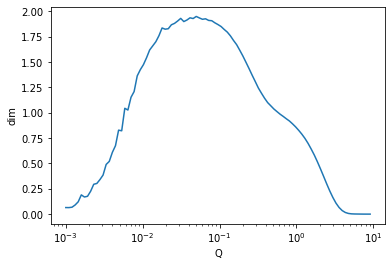

In [250]:
plt.plot(Qs[:-1],derivative)
plt.semilogx()
plt.xlabel("Q")
plt.ylabel("dim")
plt.show()

In [238]:
distmat.shape

(10000, 10000)

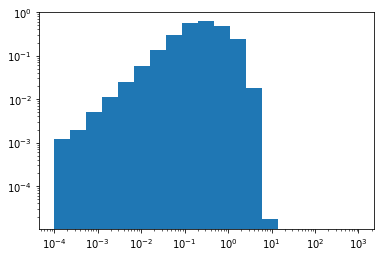

In [248]:
plt.hist(distmat.flatten(),bins = np.logspace(-4,3,20),density = True)
plt.semilogx()
plt.semilogy()
plt.show()

In [255]:
mymat = np.array([[[0,0],[1,1]],[[1,1]],[[0,0]]])

In [252]:
np.linalg.norm(mymat,axis=-1)

TypeError: loop of ufunc does not support argument 0 of type list which has no callable conjugate method

In [257]:
np.array([[[0,0],[1,1]],[[1,1]],[[0,0]]]).shape

(3,)